# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

%cd drive/MyDrive/inv/investments_project

Mounted at /content/drive
/content/drive/MyDrive/inv/investments_project


---
# IMPORTS and UTILS

In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
import seaborn as sns

In [ ]:
# UTILS

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

def annualized_metrics(returns, rf=0.0):
    mean_return = (returns-rf).mean() * 12
    std_dev = returns.std() * np.sqrt(12)
    sharpe_ratio = mean_return / std_dev
    return mean_return, std_dev, sharpe_ratio

# ----------------------------------- Plots ---------------------------------- # 

def plot_strategy_performance(data, metrics, columns):
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111)  # Add a single subplot

    data.plot(kind='bar', x='Metric', y=columns,
                ax=ax, legend=True)
    ax.set_title('IV Factors Strategy Metrics')
    ax.set_ylabel('Value')

    plt.tight_layout()
    plt.show()

def plot_metrics(returns, title):
    # Calculate annualized mean, standard deviation, and Sharpe ratio
    metrics = returns.apply(annualized_metrics)

    # As DataFrame
    metrics_df = metrics.T.rename(columns={0: 'Mean', 1: 'Volatility', 2: 'Sharpe Ratio'})

    if len(metrics_df) > len(metrics):
        fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 10))
    else:
        fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6))

    for i, m in enumerate(metrics_df.columns):
        sns.barplot(metrics_df[m], ax=axes[i])
        axes[i].set_title(m)
        #axes[i].set_xlabel(m)
        axes[i].set_ylabel(m)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# --------------------------- Weighting Strategies --------------------------- #

# Equal weight strategy
def ew_strategy(data, asset_columns):
    strategy_returns = data[asset_columns].mean(axis=1)
    return strategy_returns

# Value weight strategy
def vw_strategy(data, asset_columns):
    strategy_returns = data[asset_columns].apply(lambda x: np.average(x['Rn'], weights=x['mcap']), axis=1)
    return strategy_returns

# Risk parity strategy
def rp_strategy(data, asset_columns):
    volatilities = data[asset_columns].rolling(window=12).std()
    inverse_vols = 1 / volatilities
    weights = inverse_vols.div(inverse_vols.sum(axis=1), axis=0)
    returns = (weights * data[asset_columns]).sum(axis=1)
    weights.columns = [f'w_{a}' for a in asset_columns]
    return weights, returns

# Mean-variance optimization strategy
def mv_strategy(data, columns):
    returns = data[columns]

    mu = returns.mean()
    rf = data['rf'].mean()

    sigma = returns.cov()
    sigma_inv = np.linalg.inv(sigma)

    A = np.sum(sigma_inv)
    B = np.sum(sigma_inv @ mu)

    w_tan = sigma_inv @ (mu - rf) / (B - A*rf)

    strategy_returns = returns @ w_tan
    return strategy_returns

# ---------------------------------- Scaling --------------------------------- #
def scale_to_target_volatility(strategy_returns, target_vol=0.10):
    annual_vol = strategy_returns.std() * np.sqrt(12)
    scale_factor = target_vol / annual_vol
    return strategy_returns * scale_factor

## CODE for part 8

In [ ]:
DATA_PATH = "../data"

def bab(i):
    import numpy as np
    import datetime
    import pandas as pd
    import matplotlib.pyplot as plt
    import datetime
    #import wrds
    import utils
    import seaborn as sns

    pd.options.mode.chained_assignment = None
    #data = pd.read_parquet('slow_part.parquet')
    data = pd.read_parquet(f'{DATA_PATH}/slow_part.parquet')
    import re
    #with open('Siccodes12.txt', 'r') as file:
    with open(f'{DATA_PATH}/Siccodes12.txt', 'r') as file:
        lines = file.readlines()



    ff12_mapping = []
    current_ff12 = None

    for line in lines:
        
        category_match = re.match(r'^\s*(\d+)\s+\w+', line)
        if category_match:
            current_ff12 = int(category_match.group(1))
        else:
            
            interval_match = re.match(r'^\s*(\d+)-(\d+)', line)
            if interval_match:
                start = int(interval_match.group(1))
                end = int(interval_match.group(2))
                ff12_mapping.append((start, end, current_ff12))

    def map_siccd_to_ff12(siccd):
        for start, end, ff12 in ff12_mapping:
            if start <= siccd <= end:
                return ff12
        return None


    data['FF12'] = data['siccd'].apply(map_siccd_to_ff12)
    #data['FF12'].fillna(12, inplace=True)
    data['FF12'] = data['FF12'].fillna(12)



    data = data[data['FF12'] == i]

    df = data
    average_beta_permno = df.groupby('permno')['beta'].mean()

    df['month'] = df['date'].dt.to_period('M')
    average_beta_month = df.groupby('month')['beta'].mean()
    average_beta_month_sorted = average_beta_month.sort_index()

    def annualize_return(monthly_return):
        return ((1 + monthly_return)**12 - 1)

    def sharpe_ratio(mean_return, std_dev, risk_free_rate):
        return (mean_return - risk_free_rate) / std_dev

    data = data.dropna(subset=['beta']).copy()
    data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

    data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

    data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
    ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
    vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()
    vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()

    ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
    ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()
    ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

    vw_ret_mean_annual = annualize_return(vw_ret_mean)
    ew_ret_mean_annual = annualize_return(ew_ret_mean)

    vw_ret_std_annual = vw_ret_std * np.sqrt(12)
    ew_ret_std_annual = ew_ret_std * np.sqrt(12)
    risk_free_rate_annual = annualize_return(data['rf'].mean())

    vw_sharpe_ratios = sharpe_ratio(vw_ret_mean_annual, vw_ret_std_annual,risk_free_rate_annual)
    ew_sharpe_ratios = sharpe_ratio(ew_ret_mean_annual, ew_ret_std_annual,risk_free_rate_annual)

    deciles = ['D' + str(x) for x in range(1, 11)]






    # *c)*

    # In[ ]:


    # Weights
    data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
    data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
    data['k'] = np.abs(data['z_'])
    data['k'] = 2/data.groupby('date')['k'].transform('sum')
    data['w_H'] = data['k'] * data['z_'] * (data['z_']>0)
    data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0)




    # d)

    # In[21]:


    # Weighted returns and beta
    data['beta_H'] = data['w_H'] * data['beta']
    data['beta_L'] = data['w_L'] * data['beta']
    data['R_H'] = data['w_H'] * data['Rn']
    data['R_L'] = data['w_L'] * data['Rn']
    data['R_H_e'] = data['w_H'] * data['Rn_e']
    data['R_L_e'] = data['w_L'] * data['Rn_e']
    BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
    df_Rf = data[['rf','date','Rm']]
    df_Rf['date'] = df['date'].dt.strftime('%Y-%m')

    BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']
    BAB_final = BAB.drop(columns=['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L'])
    BAB_final['date'] = BAB_final['date'].dt.strftime('%Y-%m')
    BAB_final['BAB'] = BAB_final['BAB2']
    BAB_final = BAB_final.merge(df_Rf, on='date', how='left')
    BAB_final = BAB_final.drop(columns=['BAB2','rf','Rm'])
    BAB_final = BAB_final.drop_duplicates(subset=['BAB'])


    return BAB_final


def mom(i):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    from scipy import stats

    from utils import plot_metrics

    # Load the data
    q=10
    data = pd.read_parquet(f'{DATA_PATH}/deciles/mom_deciles.parquet')
    import re
    #with open('Siccodes12.txt', 'r') as file:
    with open(f'{DATA_PATH}/Siccodes12.txt', 'r') as file:
        lines = file.readlines()
    


    ff12_mapping = []
    current_ff12 = None

    for line in lines:
        
        category_match = re.match(r'^\s*(\d+)\s+\w+', line)
        if category_match:
            current_ff12 = int(category_match.group(1))
        else:
            
            interval_match = re.match(r'^\s*(\d+)-(\d+)', line)
            if interval_match:
                start = int(interval_match.group(1))
                end = int(interval_match.group(2))
                ff12_mapping.append((start, end, current_ff12))

    def map_siccd_to_ff12(siccd):
        for start, end, ff12 in ff12_mapping:
            if start <= siccd <= end:
                return ff12
        return None


    data['FF12'] = data['siccd'].apply(map_siccd_to_ff12)
    #data['FF12'].fillna(12, inplace=True)
    data['FF12'] = data['FF12'].fillna(12)
    data = data[data['FF12'] == i]

    data = data[data.permno.isin(data.permno.unique()[:100])]

    
    data.shape

    ew_returns = data.groupby(['date', 'decile'])['Rn'].mean().unstack()



    # In[32]:


    # Compute value-weighted returns for each decile
    vw_returns = data.groupby(['date', 'decile']).apply(lambda x: np.average(x['Rn'], weights=x['mcap'])).unstack()

    
    short_d = range(1, 4)
    long_d = range(q-2, q+1)

    data['w_L_ew'] = (data['decile'].isin(long_d))
    data['w_L_ew'] = data['w_L_ew']/data.groupby(['date'])['w_L_ew'].transform('sum')

    data['w_S_ew'] = (data['decile'].isin(short_d))
    data['w_S_ew'] = data['w_S_ew']/data.groupby(['date'])['w_S_ew'].transform('sum')

    data['w_MoM_ew'] = data['w_L_ew'] + data['w_S_ew']

    long_ew = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_L_ew'])).reset_index()[0]
    short_ew = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_S_ew'])).reset_index()[0]
    mom_ew = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_MoM_ew'])).reset_index()[0]


    data['w_L_vw'] = (data['decile'].isin(long_d))*data['mcap']
    data['w_L_vw'] = data['w_L_vw'] / data.groupby(['date'])['w_L_vw'].transform('sum')

    data['w_S_vw'] = (data['decile'].isin(short_d))*data['mcap']
    data['w_S_vw'] = data['w_S_vw']/data.groupby(['date'])['w_S_vw'].transform('sum')

    data['w_MoM_vw'] = data['w_L_vw'] + data['w_S_vw']

    long_vw = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_L_vw'])).reset_index()
    short_vw = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_S_vw'])).reset_index()
    mom_vw = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_MoM_vw'])).reset_index()


    mom_vw.columns = ['date', 'MoM']
    mom_vw['date'] = mom_vw['date'].dt.to_period('M')
    return mom_vw


def iv(i):


    import numpy as np
    import datetime
    import pandas as pd
    import matplotlib.pyplot as plt
    import datetime
    #import wrds
    import seaborn as sns
    from statsmodels.regression.rolling import RollingOLS
    import statsmodels.api as sm
    from scipy.stats import ttest_1samp
    from scipy.stats import mstats

    sns.set_theme(style='whitegrid')


    from utils import plot_strategy_performance


    # ---
    # # Load the data

    # In[7]:


    # Complete data
    #data = pd.read_parquet('stock_data.parquet')
    data = pd.read_parquet(f'{DATA_PATH}/stock_data.parquet')
    import re
    #with open('Siccodes12.txt', 'r') as file:
    with open(f'{DATA_PATH}/Siccodes12.txt', 'r') as file:
        lines = file.readlines()


    ff12_mapping = []
    current_ff12 = None

    for line in lines:
        
        category_match = re.match(r'^\s*(\d+)\s+\w+', line)
        if category_match:
            current_ff12 = int(category_match.group(1))
        else:
            
            interval_match = re.match(r'^\s*(\d+)-(\d+)', line)
            if interval_match:
                start = int(interval_match.group(1))
                end = int(interval_match.group(2))
                ff12_mapping.append((start, end, current_ff12))

    def map_siccd_to_ff12(siccd):
        for start, end, ff12 in ff12_mapping:
            if start <= siccd <= end:
                return ff12
        return None


    data['FF12'] = data['siccd'].apply(map_siccd_to_ff12)
    #data['FF12'].fillna(12, inplace=True)
    data['FF12'] = data['FF12'].fillna(12)
    data = data[data['FF12'] == i]

    data = data[data.permno.isin(data.permno.unique()[:100])]

    
    data.shape


    # In[9]:


    data['date'] = pd.to_datetime(data['date'])  
    


    # ---
    # # Idiosyncratic Volatility Strategy (IV)
    # 
    # (a) Compute the time-varying estimate for each stock’s idiosyncratic volatility $ σ^{idio}_{t,n} $ obtained as the volatility of the residual in the monthly rolling 5-year regressions of
    # stock-specific excess returns on the excess market return. Require at least 36 months
    # of observations for each stock. Winsorize the volatility at 5 and 95 %.

    # In[10]:


    # Remove any potential NaN values
    data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

    # Remove rare stocks with less than 60 observations
    data['N'] = data.groupby(['permno'])['date'].transform('count')
    data = data[data['N']>60].copy()

    # Calculate the rolling covariance matrix
    cov_nm = data.set_index('date').groupby('permno')[['Rn_e', 'Rm_e']].rolling(60, min_periods=36).cov()

    # Extract the required components
    cov_ee = cov_nm.iloc[0::2, 0].droplevel(2)
    cov_em = cov_nm.iloc[0::2, 1].droplevel(2)
    cov_mm = cov_nm.iloc[1::2, 1].droplevel(2)

    # Calculate idio vol
    beta = cov_em / cov_mm
    idio_variance = cov_ee - beta**2 * cov_mm
    idio_volatility = np.sqrt(idio_variance).dropna()

    # Add the idiosyncratic volatility to the original dataframe
    data = data.set_index(['permno', 'date'])
    data['sigma_idio'] = idio_volatility

    # Reset index to merge correctly
    data = data.reset_index()

    # Winsorize the idiosyncratic volatility at 5% and 95%
    data['sigma_idio'] = data['sigma_idio'].clip(data['sigma_idio'].quantile(0.05),data['sigma_idio'].quantile(0.95))


    # In[11]:


    


    # - Look up on the volatilities

    # In[12]:


    # Select five unique stocks for plotting
    selected_stocks = data['permno'].unique()[:25]

    # Filter data for the selected stocks
    filtered_data = data[data['permno'].isin(selected_stocks)]

    


    # (b) At every month t, sort all stocks into deciles based on their idiosyncratic volatility
    # (estimated using the most recent rolling window). Then compute monthly returns for
    # 10 decile portfolios that equal weight all stocks in each decile. Plot the average annu-
    # alized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in
    # three barplots. Repeat for value-weighted decile portfolios. Summarize your findings.
    # Is the evidence consistent with the CAPM?

    # In[13]:


    # Sort stocks into deciles based on idiosyncratic volatility at each month
    data = data.dropna(subset=['sigma_idio']).copy()
    data['sigma_idio_decile'] = data.groupby('date')['sigma_idio'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

    # Compute market weights within quintiles
    data['vw_Q'] = data['mcap'] / data.groupby(['date', 'sigma_idio_decile'])['mcap'].transform('sum')

    # Compute value-weighted returns for each decile
    data['idio_ret_vw'] = data['vw_Q'] * data['Rn_e']
    ret_vw = data.groupby(['date', 'sigma_idio_decile'])['idio_ret_vw'].sum().reset_index()
    vw_ret_mean = ret_vw.groupby('sigma_idio_decile')['idio_ret_vw'].mean()

    # Compute equal-weighted returns for each decile
    ret_ew = data.groupby(['date', 'sigma_idio_decile'])['Rn_e'].mean().reset_index()
    ew_ret_mean = ret_ew.groupby('sigma_idio_decile')['Rn_e'].mean()


    # In[14]:


    # Calculate annualized portfolio statistics
    def calculate_stats(returns):
        mean_return = returns.mean() * 12
        std_dev = returns.std() * np.sqrt(12)
        sharpe_ratio = mean_return / std_dev
        return mean_return, std_dev, sharpe_ratio

    # Compute value-weighted portfolio statistics
    vw_stats = ret_vw.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['idio_ret_vw']))

    # Compute equal-weighted portfolio statistics
    ew_stats = ret_ew.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['Rn_e']))


    # In[15]:


   


    # In[16]:


    


    # (c) Now we construct the idiosyncratic volatility factor. At every month t, we go long
    # the three highest decile volatility portfolios and we go short the three lowest decile
    # volatility portfolios. Compute and compare the mean, standard deviation, and Sharpe
    # ratios of the long and short legs of the strategy as well as of the strategy itself. Test if
    # the strategy has an average return that is statistically significantly different from zero.
    # Repeat both tests for equal and value-weighted portfolios. How do your results differ
    # from Ang, Hodrick, Xing, and Zhang (2006; table VI page 285) and what may be the
    # explanation for the difference?

    # In[17]:


    #  Select stocks for long and short legs
    long_leg_data = data[data['sigma_idio_decile'] >= 7]
    short_leg_data = data[data['sigma_idio_decile'] < 3]

    # Compute portfolio returns for long and short legs
    long_leg_returns_vw = long_leg_data.groupby('date')['idio_ret_vw'].sum()
    short_leg_returns_vw = short_leg_data.groupby('date')['idio_ret_vw'].sum()
    long_leg_returns_ew = long_leg_data.groupby('date')['Rn_e'].mean()
    short_leg_returns_ew = short_leg_data.groupby('date')['Rn_e'].mean()

    # Calculate factor returns
    factor_returns_vw = long_leg_returns_vw - short_leg_returns_vw
    factor_returns_ew = long_leg_returns_ew - short_leg_returns_ew

    # Factor returns
    factor_mean_return_vw = factor_returns_vw.mean() * 12
    factor_std_dev_vw = factor_returns_vw.std() * np.sqrt(12)
    factor_sharpe_ratio_vw = factor_mean_return_vw / factor_std_dev_vw

    factor_mean_return_ew = factor_returns_ew.mean() * 12
    factor_std_dev_ew = factor_returns_ew.std() * np.sqrt(12)
    factor_sharpe_ratio_ew = factor_mean_return_ew / factor_std_dev_ew

    # Long and Short legs
    long_mean_return_vw = long_leg_returns_vw.mean() * 12
    long_std_dev_vw = long_leg_returns_vw.std() * np.sqrt(12)
    long_sharpe_ratio_vw = long_mean_return_vw / long_std_dev_vw

    short_mean_return_vw = short_leg_returns_vw.mean() * 12
    short_std_dev_vw = short_leg_returns_vw.std() * np.sqrt(12)
    short_sharpe_ratio_vw = short_mean_return_vw / short_std_dev_vw

    long_mean_return_ew = long_leg_returns_ew.mean() * 12
    long_std_dev_ew = long_leg_returns_ew.std() * np.sqrt(12)
    long_sharpe_ratio_ew = long_mean_return_ew / long_std_dev_ew

    short_mean_return_ew = short_leg_returns_ew.mean() * 12
    short_std_dev_ew = short_leg_returns_ew.std() * np.sqrt(12)
    short_sharpe_ratio_ew = short_mean_return_ew / short_std_dev_ew


    # Significance test
    t_stat_vw, p_value_vw = ttest_1samp(factor_returns_vw, 0)
    t_stat_ew, p_value_ew = ttest_1samp(factor_returns_ew, 0)





    stats_data = pd.DataFrame({
        'Metric': ['Mean Return', 'Standard Deviation', 'Sharpe Ratio'],
        'Factor Returns (Value-Weighted)': [factor_mean_return_vw, factor_std_dev_vw, factor_sharpe_ratio_vw],
        'Factor Returns (Equal-Weighted)': [factor_mean_return_ew, factor_std_dev_ew, factor_sharpe_ratio_ew],
        'Long Leg (Value-Weighted)': [long_mean_return_vw, long_std_dev_vw, long_sharpe_ratio_vw],
        'Short Leg (Value-Weighted)': [short_mean_return_vw, short_std_dev_vw, short_sharpe_ratio_vw],
        'Long Leg (Equal-Weighted)': [long_mean_return_ew, long_std_dev_ew, long_sharpe_ratio_ew],
        'Short Leg (Equal-Weighted)': [short_mean_return_ew, short_std_dev_ew, short_sharpe_ratio_ew]
    })
    stats_data


    # In[20]:


    # Stats metrics
    metrics = ['Mean Return', 'Standard Deviation', 'Sharpe Ratio']

    
    # In[22]:


    # Load data for next section 
    IV = factor_returns_vw.reset_index().rename(columns={'idio_ret_vw': 'IV'})
    IV['date'] = IV['date'].dt.to_period('M')

    return IV

---
# The Data

In [ ]:
# WRDS connection Set up

# Your Username here
username = "maallard"

db=wrds.Connection(wrds_username=username)
db.create_pgpass_file()

Loading library list...
Done


**Download:**
- Monthly stock returns from CRSP from January 1, 1964, to December 31, 2023, for all common stocks traded on the NYSE and AMEX.
- The value-weighted CRSP market return and 1-month T-bill returns as a risk-free rate.

In [ ]:
### Download and format data

#---------------------------------------------
# Risk Free Rate
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm
            from crsp.tfz_mth_rf
            where kytreasnox = 2000001
            and mcaldt>='1964-01-01'
            and mcaldt<='2023-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi
                where date>='1964-01-01' and date<='2023-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns
#---------------------------------------------

stock_data = db.raw_sql("""
                    select a.permno, a.date, a.ret, a.shrout, a.prc, b.siccd
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1964' and '12/31/2023'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date'])
stock_data = stock_data.rename(columns={'ret':'Rn'})


#---------------------------------------------
# Merge Data
#---------------------------------------------

# Merge all data
merged_data = pd.merge(stock_data, Rm, on='date')
merged_data = pd.merge(merged_data, Rf, on='date')

# Save CSV
merged_data.to_csv('merged_stock_data.csv', index=False)

## Load and Prepare DATA

In [ ]:
data = pd.read_csv("../data/merged_stock_data.csv")

In [ ]:
# CLEAN
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['permno', 'date']) # Sort the data by 'permno' and 'date'
data['mcap'] = np.abs(data['prc']) * data['shrout'] # Market capitalization
data['mcap_l'] = data.groupby(['permno'])['mcap'].shift(1) # Lagged market capitalization
data['Rn_f'] = data.groupby(['permno'])['Rn'].shift(-1) # Future stock return
# CST col
data['const'] = 1
# Excess returns
data['Rn_e'] = data['Rn'] - data['rf']
data['Rm_e'] = data['Rm'] - data['rf']
# Market capitalization weight
data['w_m'] = data['mcap_l'] / data.groupby(['date'])['mcap_l'].transform('sum')

# Drop na rows
data = data.dropna(subset=['mcap_l', 'Rn_e', 'Rm_e']).copy()

data.head()

,permno,date,Rn,shrout,prc,siccd,Rm,rf,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m
5,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,-0.037172,0.000013,43871.6600,44918.3000,-0.000656,1,-0.018945,-0.037185,0.000005
4,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.034744,0.000061,43646.6324,43871.6600,0.020643,1,-0.000717,0.034683,0.000005
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.063668,0.000112,44351.3700,43646.6324,0.124385,1,0.020531,0.063556,0.000005
2,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.020036,0.000118,69137.3000,44351.3700,0.004829,1,0.124267,0.019918,0.000004
1,10001,2010-05-28,0.004829,6071.0,11.4000,4925,-0.079240,0.000114,69209.4000,69137.3000,-0.043421,1,0.004715,-0.079354,0.000007


In [ ]:
data.to_parquet('stock_data.parquet')
merged_data.to_parquet('merged_stock_data.parquet')

In [21]:
data = pd.read_parquet('./data/stock_data.parquet')
merged_data = pd.read_parquet('./data/merged_stock_data.parquet')

# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

---
# Imports

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import wrds
import seaborn as sns
import statsmodels.api as sm

---
# The Data

*Download monthly stock returns from CRSP from January 1, 1964, to December 31, 2023, for all common stocks traded on the NYSE and AMEX. Also, download the value-weighted CRSP market return and 1-month T-bill returns as a risk-free rate. Many of the relevant SQL requests or Python commands are found in the previous exercises covered earlier during the semester.*

In [2]:
data = pd.read_parquet('../data/stock_data.parquet')

---
# Betting against Beta strategy (BaB)

*a) Compute the time-varying market βt,n for each stock by running monthly rolling 5-
year regressions of stock-specific excess returns on the excess market return. Require
at least 36 months of observations for each stock. Winsorize the beta at 5 and 95 %.*

In [ ]:
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm
data = data.dropna(subset=['mcap_l', 'Rn_e', 'Rm_e']).copy()

data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N'] > 60].copy()
tqdm.pandas()

# 2. Function to calculate rolling beta using OLS regression
def calculate_rolling_beta(group, window=60, min_periods=36):
    group = group.sort_values('date')
    betas = pd.Series(index=group.index, dtype=float)
    for start in (range(len(group) - min_periods + 1)):
        end = start + window
        if end > len(group):
            end = len(group)
        subset = group.iloc[start:end]
        if len(subset) >= min_periods:
            X = sm.add_constant(subset['Rm_e'])
            y = subset['Rn_e']
            model = sm.OLS(y, X).fit()
            betas.iloc[end-1] = model.params['Rm_e']
    return betas

data['beta'] = data.groupby('permno').progress_apply(calculate_rolling_beta).reset_index(level=0, drop=True)

beta_5th = data['beta'].quantile(0.05)
beta_95th = data['beta'].quantile(0.95)
data['beta'] = data['beta'].clip(lower=beta_5th, upper=beta_95th)

data = data.drop(columns=['N'])
data.to_parquet('slow_part.parquet')


In [2]:
import pandas as pd
data = pd.read_parquet('../data/slow_part.parquet')
df = data

*b) At every month t, sort all stocks into deciles based on their beta (estimated using the most recent rolling window). Then compute monthly returns for 10 decile portfolios that equal weight all stocks in each decile. Plot the average annualized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in three bar plots. Repeat for value-weighted decile portfolios. Summarize our findings. Is the evidence consistent with the CAPM?*

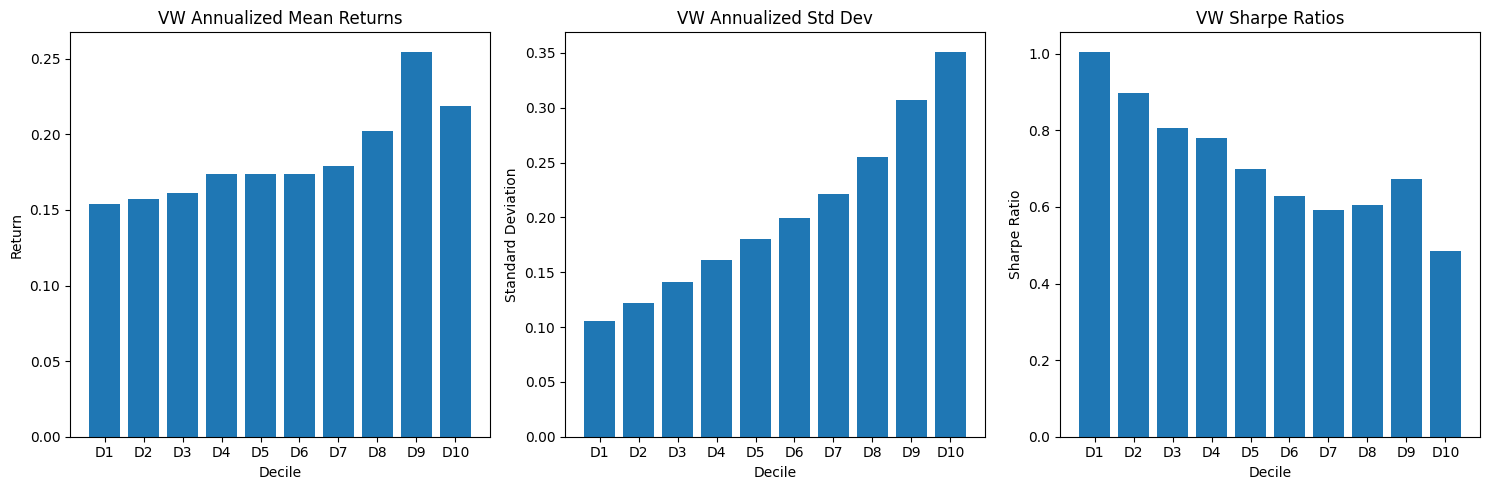

<BarContainer object of 10 artists>

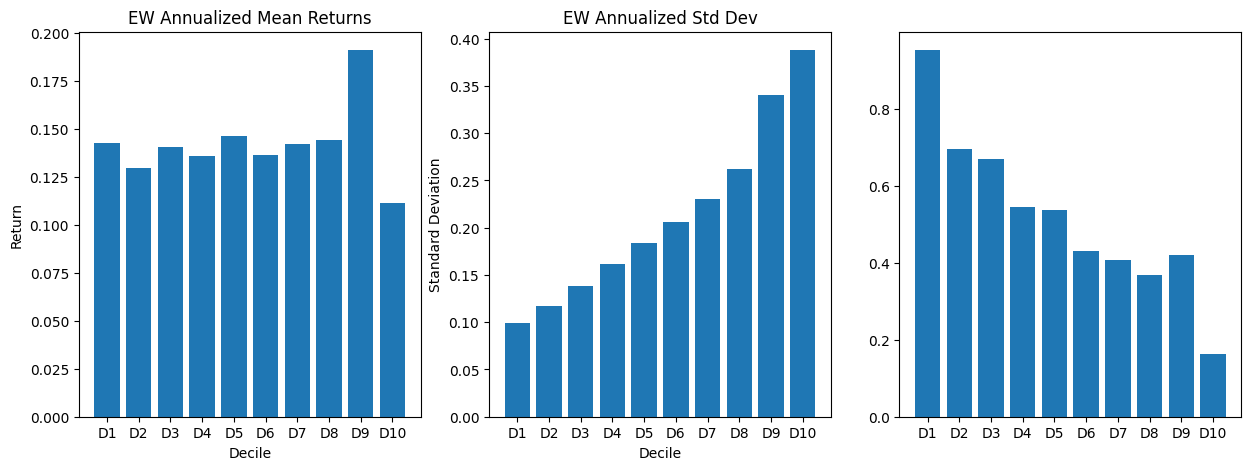

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def annualize_return(monthly_return):
    return ((1 + monthly_return)**12 - 1)

def sharpe_ratio(mean_return, std_dev, risk_free_rate):
    return (mean_return - risk_free_rate) / std_dev

data = data.dropna(subset=['beta']).copy()
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()

ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

vw_ret_mean_annual = annualize_return(vw_ret_mean)
ew_ret_mean_annual = annualize_return(ew_ret_mean)

vw_ret_std_annual = vw_ret_std * np.sqrt(12)
ew_ret_std_annual = ew_ret_std * np.sqrt(12)
risk_free_rate_annual = annualize_return(data['rf'].mean())

vw_sharpe_ratios = sharpe_ratio(vw_ret_mean_annual, vw_ret_std_annual,risk_free_rate_annual)
ew_sharpe_ratios = sharpe_ratio(ew_ret_mean_annual, ew_ret_std_annual,risk_free_rate_annual)

deciles = ['D' + str(x) for x in range(1, 11)]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(deciles, vw_ret_mean_annual)
plt.title('VW Annualized Mean Returns')
plt.xlabel('Decile')
plt.ylabel('Return')

plt.subplot(1, 3, 2)
plt.bar(deciles, vw_ret_std_annual)
plt.title('VW Annualized Std Dev')
plt.xlabel('Decile')
plt.ylabel('Standard Deviation')

plt.subplot(1, 3, 3)
plt.bar(deciles, vw_sharpe_ratios)
plt.title('VW Sharpe Ratios')
plt.xlabel('Decile')
plt.ylabel('Sharpe Ratio')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(deciles, ew_ret_mean_annual)
plt.title('EW Annualized Mean Returns')
plt.xlabel('Decile')
plt.ylabel('Return')

plt.subplot(1, 3, 2)
plt.bar(deciles, ew_ret_std_annual)
plt.title('EW Annualized Std Dev')
plt.xlabel('Decile')
plt.ylabel('Standard Deviation')

plt.subplot(1, 3, 3)
plt.bar(deciles, ew_sharpe_ratios)


*c)*

In [4]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0)
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0)




d)

In [5]:
# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()


In [15]:
df_Rf = df[['rf','date','Rm']]
df_Rf['date'] = pd.to_datetime(df_Rf['date']).dt.strftime('%Y-%m')
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']
BAB_final = BAB.drop(columns=['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L'])
BAB_final['date'] = BAB_final['date'].dt.strftime('%Y-%m')
BAB_final['BAB'] = BAB_final['BAB2']
BAB_final = BAB_final.merge(df_Rf, on='date', how='left')
BAB_final = BAB_final.drop(columns=['BAB2'])
BAB_final.drop_duplicates(inplace=True)

/var/folders/1y/cd26kgpx7jd535tgk4gkf_3r0000gn/T/ipykernel_23455/1637187380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Rf['date'] = pd.to_datetime(df_Rf['date']).dt.strftime('%Y-%m')


In [27]:
mean_bab = BAB_final['BAB'].mean()
std_bab = BAB_final['BAB'].std()
sharpe_ratio = (mean_bab) / std_bab
BAB_final['const'] = 1

BAB_final.dropna()

BAB_final['excess_market'] = BAB_final['Rm'] - BAB_final['rf']
X = BAB_final[['excess_market','const']]
y = BAB_final['BAB']
capm_model = sm.OLS(y, X).fit()
capm_alpha = capm_model.params[1]

print(f"Mean BAB: {mean_bab}")
print(f"Standard Deviation BAB: {(std_bab)}")
print(f"Sharpe Ratio BAB: {sharpe_ratio}")
print(f"CAPM Alpha BAB: {capm_alpha*12}")


Mean BAB: 0.0087138468247437
Standard Deviation BAB: 0.03962929888544308
Sharpe Ratio BAB: 0.21988395126375887
CAPM Alpha BAB: 0.11846480382496935


/var/folders/1y/cd26kgpx7jd535tgk4gkf_3r0000gn/T/ipykernel_23455/1855752364.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  capm_alpha = capm_model.params[1]


In [ ]:
data.to_parquet('stock_data_part1.parquet')


#### BaB Weights calclus for Ex7

In [7]:
BAB_weights = data[['date','permno','w_H','w_L']].merge(BAB[['date','beta_H','beta_L']],on='date',how='left')
BAB_weights['BaB_strat'] =  BAB_weights['w_L'] / BAB_weights['beta_L']
BAB_weights['BaB_strat'] = BAB_weights['BaB_strat'].fillna(0)
BAB_weights['BaB_strat'] -= BAB_weights['w_H'] / BAB_weights['beta_H']
BAB_weights['BaB_strat'] = BAB_weights['BaB_strat'].fillna(0)


In [8]:
BAB_weights[['date','permno','BaB_strat']].to_parquet('BaB_weights.parquet')

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from utils import plot_metrics

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
DATA_PATH = "../data"

---
# 4 - Momentum Strategy (Mom)

*a) Construct the return to a long-short momentum strategy portfolio. To that effect every month sort stocks into deciles based on their 1-month lagged 11-month return (that is in month $t$ rank stocks based on their $t$−12 to $t$−1 cumulative return). <br></br> Then compute monthly returns for 10 decile portfolios that equal weight all stocks in each decile. Plot the average annualized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in three bar plots. Repeat for value-weighted decile portfolios. Is the evidence consistent with the CAPM?*

In [169]:
# Load the data
data = pd.read_parquet(f'{DATA_PATH}/stock_data.parquet')

#data = data[data.permno.isin(data.permno.unique()[:100])]

display(data.head())
data.shape

,permno,date,Rn,shrout,prc,siccd,Rm,rf,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m
5,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,-0.037172,0.000013,43871.6600,44918.3000,-0.000656,1,-0.018945,-0.037185,0.000005
4,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.034744,0.000061,43646.6324,43871.6600,0.020643,1,-0.000717,0.034683,0.000005
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.063668,0.000112,44351.3700,43646.6324,0.124385,1,0.020531,0.063556,0.000005
2,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.020036,0.000118,69137.3000,44351.3700,0.004829,1,0.124267,0.019918,0.000004
1,10001,2010-05-28,0.004829,6071.0,11.4000,4925,-0.079240,0.000114,69209.4000,69137.3000,-0.043421,1,0.004715,-0.079354,0.000007


(1425495, 15)

In [170]:
q = 10

In [171]:
# from tqdm.auto import tqdm  # for notebooks
# tqdm.pandas()

# # Ensure date is in datetime format
# data['date'] = pd.to_datetime(data['date'])

# # Calculate cumulative returns for each stock over the past 11 months
# data['cum_Rn'] = data.groupby('permno')['Rn'].rolling(11).progress_apply(lambda x: np.prod(1 + x) - 1).reset_index(level=0, drop=True)

# # Remove rows with NaN cumulative returns
# data = data.dropna(subset=['cum_Rn'])

# # Sort stocks into deciles based on cumulative return
# data['decile'] = data.groupby('date')['cum_Rn'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)

# data.to_parquet(f'{DATA_PATH}/deciles/mom_deciles.parquet')

data = pd.read_parquet(f'{DATA_PATH}/deciles/mom_deciles.parquet')

data['decile'].head()

87    4
86    3
85    4
84    5
83    4
Name: decile, dtype: int64

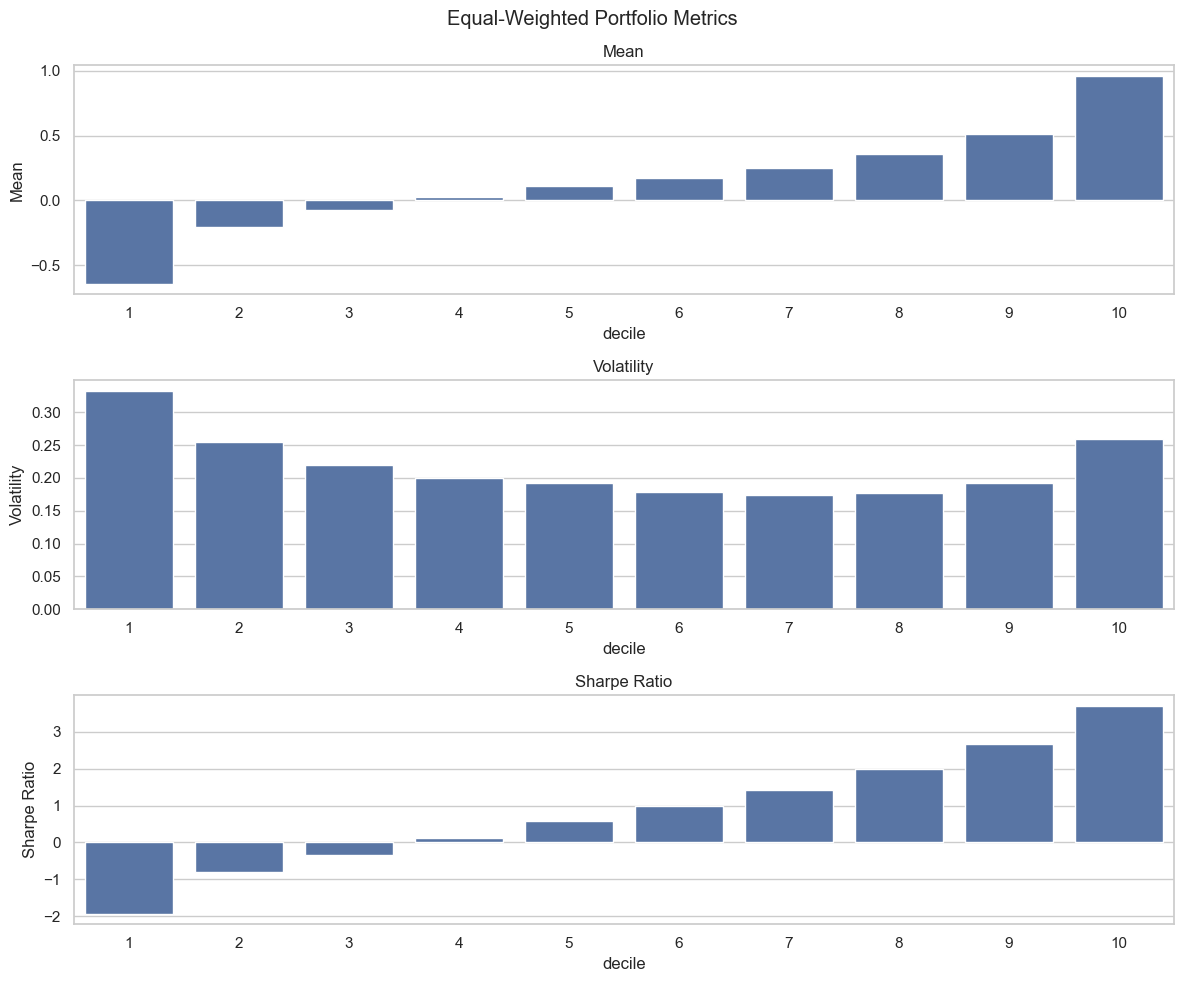

In [172]:
# Compute equal-weighted returns for each decile
ew_returns = data.groupby(['date', 'decile'])['Rn'].mean().unstack()

# Plotting the decile annual metrics
plot_metrics(ew_returns, 'Equal-Weighted Portfolio Metrics')

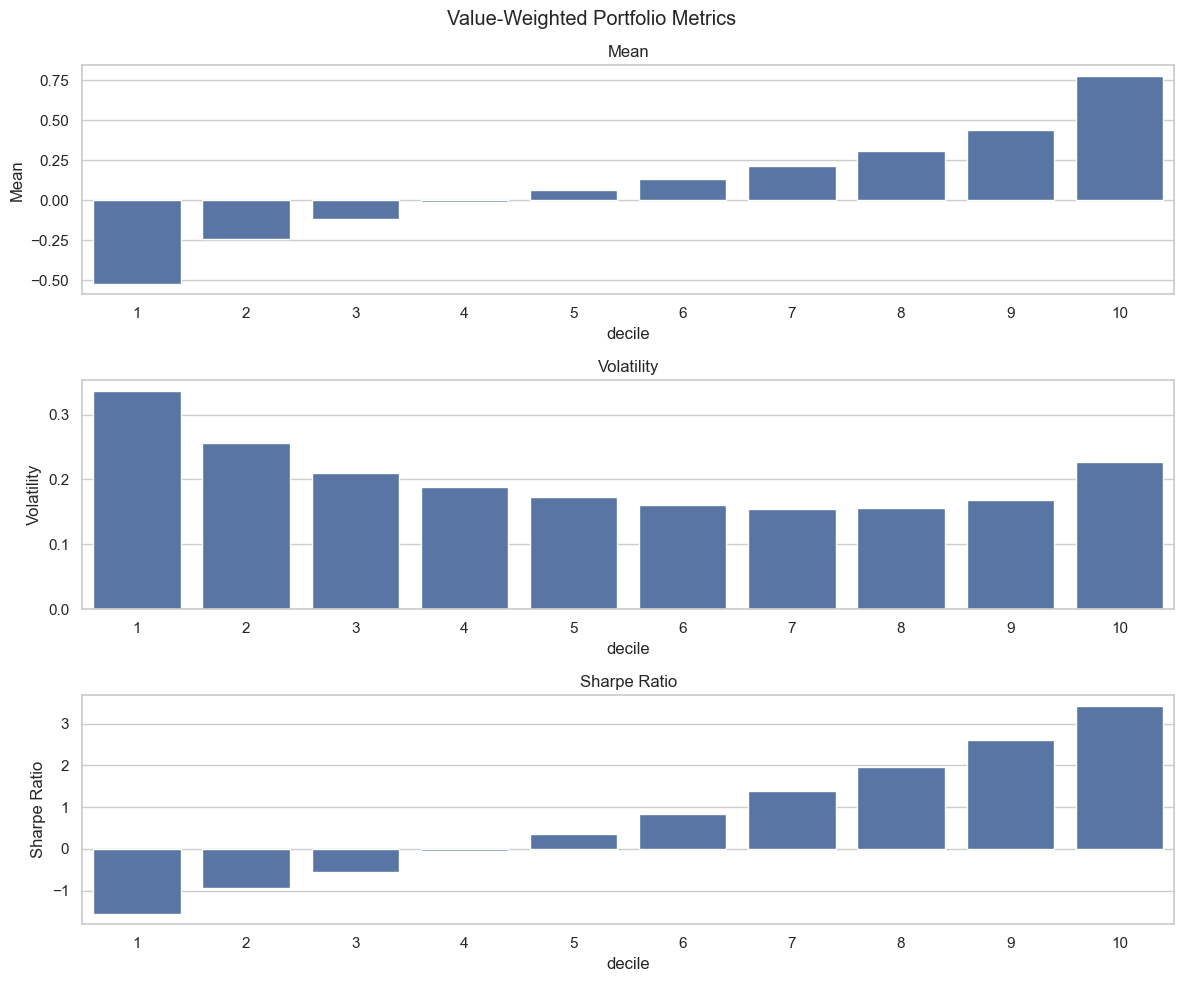

In [173]:
# Compute value-weighted returns for each decile
vw_returns = data.groupby(['date', 'decile']).apply(lambda x: np.average(x['Rn'], weights=x['mcap'])).unstack()

# Plotting the decile annual metrics
plot_metrics(vw_returns, 'Value-Weighted Portfolio Metrics')

*b) The momentum strategy is then the portfolio that goes long the three highest deciles and short the three lowest decile portfolios. Compute and compare the mean, stan- dard deviation, and Sharpe ratios of the long and short legs of the strategy as well as of the strategy itself. Test if the strategy has an average return that is statistically significantly different from zero. Repeat both tests for equal and value-weighted portfolios.*

In [174]:
short_d = range(1, 4)
long_d = range(q-2, q+1)

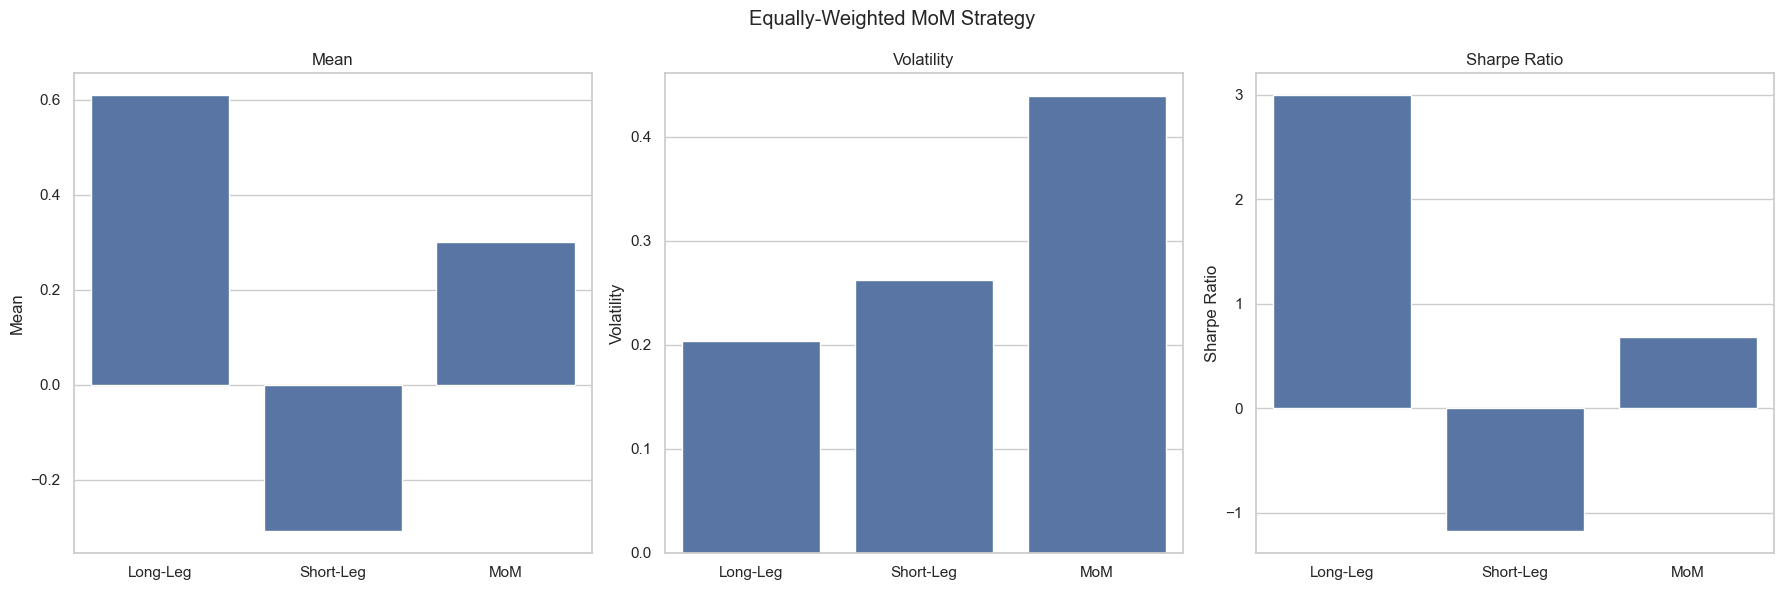

Equal-Weighted Long-Short Strategy: t-stat=5.266365628369967, p-value=1.8486248611176414e-07


In [175]:
# Long-Short Momentum Portfolio
data['w_L_ew'] = (data['decile'].isin(long_d))
data['w_L_ew'] = data['w_L_ew']/data.groupby(['date'])['w_L_ew'].transform('sum')

data['w_S_ew'] = (data['decile'].isin(short_d))
data['w_S_ew'] = data['w_S_ew']/data.groupby(['date'])['w_S_ew'].transform('sum')

data['w_MoM_ew'] = data['w_L_ew'] + data['w_S_ew']

long_ew = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_L_ew'])).reset_index()[0]
short_ew = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_S_ew'])).reset_index()[0]
mom_ew = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_MoM_ew'])).reset_index()[0]

# Plot strategy performance
plot_metrics(pd.DataFrame({'Long-Leg': long_ew,     
                            'Short-Leg': short_ew, 
                            'MoM': mom_ew}), 'Equally-Weighted MoM Strategy')

# Statistical significance testing
t_stat_equal, p_value_equal = stats.ttest_1samp(mom_ew, 0)
print(f"Equal-Weighted Long-Short Strategy: t-stat={t_stat_equal}, p-value={p_value_equal}")

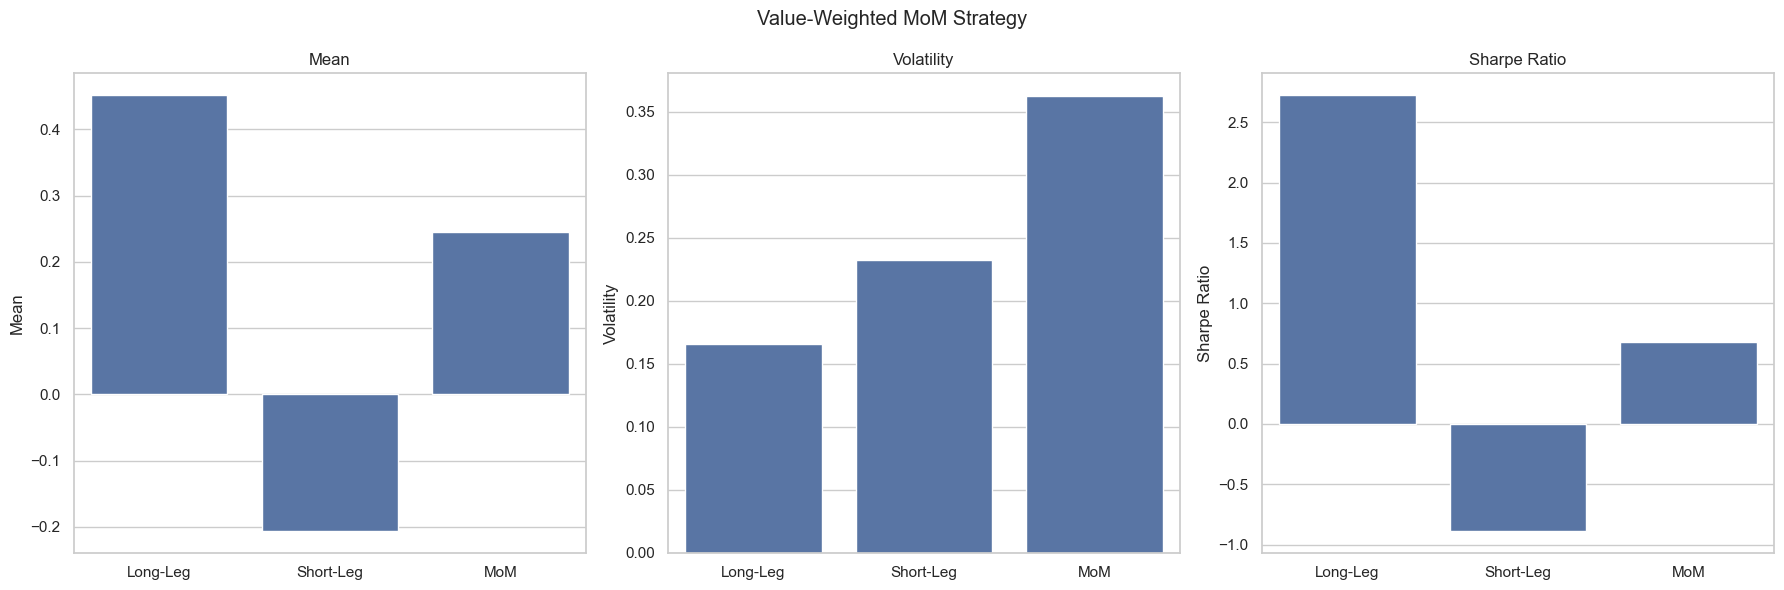

Value-Weighted Long-Short Strategy: t-stat=5.205502443122672, p-value=2.5387923133081995e-07


In [176]:
# Long-Short Momentum Portfolio
data['w_L_vw'] = (data['decile'].isin(long_d))*data['mcap']
data['w_L_vw'] = data['w_L_vw'] / data.groupby(['date'])['w_L_vw'].transform('sum')

data['w_S_vw'] = (data['decile'].isin(short_d))*data['mcap']
data['w_S_vw'] = data['w_S_vw']/data.groupby(['date'])['w_S_vw'].transform('sum')

data['w_MoM_vw'] = data['w_L_vw'] + data['w_S_vw']

long_vw = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_L_vw'])).reset_index()
short_vw = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_S_vw'])).reset_index()
mom_vw = data.groupby('date').apply(lambda x: np.sum(x['Rn']*x['w_MoM_vw'])).reset_index()

# Plot strategy performance
plot_metrics(pd.DataFrame({'Long-Leg': long_vw[0],     
                            'Short-Leg': short_vw[0], 
                            'MoM': mom_vw[0]}), 'Value-Weighted MoM Strategy')

# Statistical significance testing
t_stat_value, p_value_value = stats.ttest_1samp(mom_vw[0], 0)
print(f"Value-Weighted Long-Short Strategy: t-stat={t_stat_value}, p-value={p_value_value}")

In [177]:
mom_vw.columns = ['date', 'MoM']
mom_vw['date'] = mom_vw['date'].dt.to_period('M')
mom_vw.to_parquet(f'{DATA_PATH}/factors/mom_returns.parquet')

In [178]:
data[['date', 'permno', 'w_MoM_vw']].to_parquet(f'{DATA_PATH}/factors/mom_weights.parquet')

In [17]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import wrds
import seaborn as sns
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from scipy.stats import mstats

sns.set_theme(style='whitegrid')


from utils import plot_strategy_performance
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# Load the data

In [18]:
# Complete data
data = pd.read_parquet("../data/stock_data.parquet")

# Part 3 data (BAB
data_bab = pd.read_parquet("../data/stock_data_part1.parquet")

In [19]:
data['date'] = pd.to_datetime(data['date'])  
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1425495 entries, 5 to 1437180
Data columns (total 15 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   permno  1425495 non-null  int64         
 1   date    1425495 non-null  datetime64[ns]
 2   Rn      1425495 non-null  float64       
 3   shrout  1425495 non-null  float64       
 4   prc     1425495 non-null  float64       
 5   siccd   1425495 non-null  int64         
 6   Rm      1425495 non-null  float64       
 7   rf      1425495 non-null  float64       
 8   mcap    1425495 non-null  float64       
 9   mcap_l  1425495 non-null  float64       
 10  Rn_f    1415474 non-null  float64       
 11  const   1425495 non-null  int64         
 12  Rn_e    1425495 non-null  float64       
 13  Rm_e    1425495 non-null  float64       
 14  w_m     1425495 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(3)
memory usage: 174.0 MB


---
# Idiosyncratic Volatility Strategy (IV)

(a) Compute the time-varying estimate for each stock’s idiosyncratic volatility $ σ^{idio}_{t,n} $ obtained as the volatility of the residual in the monthly rolling 5-year regressions of
stock-specific excess returns on the excess market return. Require at least 36 months
of observations for each stock. Winsorize the volatility at 5 and 95 %.

In [20]:
# Remove any potential NaN values
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# Remove rare stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy()

# Calculate the rolling covariance matrix
cov_nm = data.set_index('date').groupby('permno')[['Rn_e', 'Rm_e']].rolling(60, min_periods=36).cov()

# Extract the required components
cov_ee = cov_nm.iloc[0::2, 0].droplevel(2)
cov_em = cov_nm.iloc[0::2, 1].droplevel(2)
cov_mm = cov_nm.iloc[1::2, 1].droplevel(2)

# Calculate idio vol
beta = cov_em / cov_mm
idio_variance = cov_ee - beta**2 * cov_mm
idio_volatility = np.sqrt(idio_variance).dropna()

# Add the idiosyncratic volatility to the original dataframe
data = data.set_index(['permno', 'date'])
data['sigma_idio'] = idio_volatility

# Reset index to merge correctly
data = data.reset_index()

# Winsorize the idiosyncratic volatility at 5% and 95%
data['sigma_idio'] = data['sigma_idio'].clip(data['sigma_idio'].quantile(0.05),data['sigma_idio'].quantile(0.95))


<Axes: >

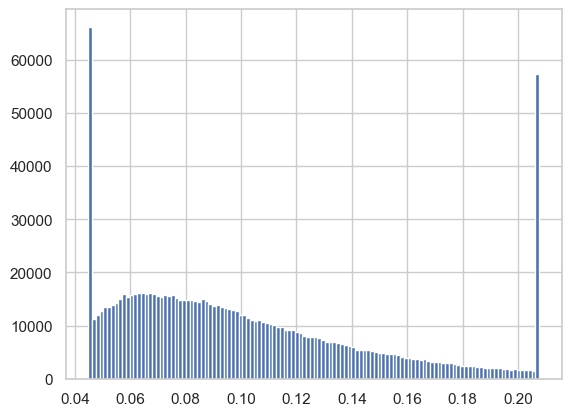

In [21]:
data['sigma_idio'].hist(bins=120)

- Look up on the volatilities

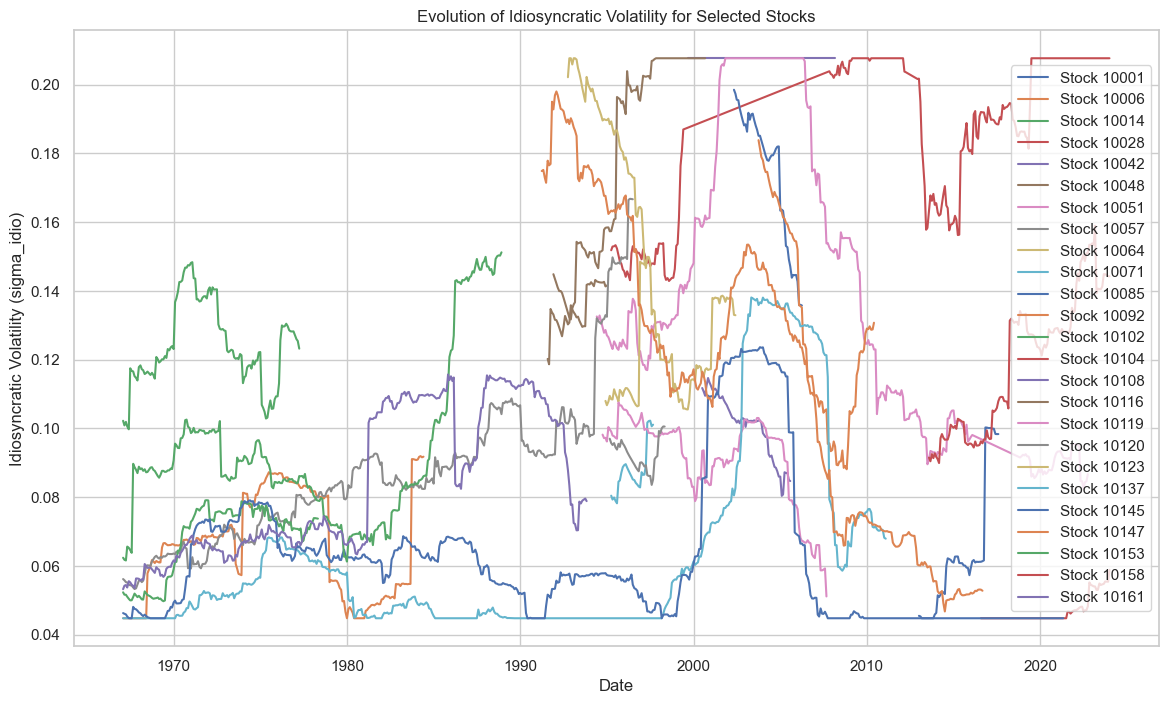

In [22]:
# Select five unique stocks for plotting
selected_stocks = data['permno'].unique()[:25]

# Filter data for the selected stocks
filtered_data = data[data['permno'].isin(selected_stocks)]

# Plot the idiosyncratic volatility over time for each selected stock
plt.figure(figsize=(14, 8))
for stock in selected_stocks:
    stock_data = filtered_data[filtered_data['permno'] == stock]
    plt.plot(stock_data['date'], stock_data['sigma_idio'], label=f'Stock {stock}')

plt.title('Evolution of Idiosyncratic Volatility for Selected Stocks')
plt.xlabel('Date')
plt.ylabel('Idiosyncratic Volatility (sigma_idio)')
plt.legend()
plt.grid(True)
plt.show()

(b) At every month t, sort all stocks into deciles based on their idiosyncratic volatility
(estimated using the most recent rolling window). Then compute monthly returns for
10 decile portfolios that equal weight all stocks in each decile. Plot the average annu-
alized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in
three barplots. Repeat for value-weighted decile portfolios. Summarize your findings.
Is the evidence consistent with the CAPM?

In [23]:
# Sort stocks into deciles based on idiosyncratic volatility at each month
data = data.dropna(subset=['sigma_idio']).copy()
data['sigma_idio_decile'] = data.groupby('date')['sigma_idio'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute market weights within quintiles
data['vw_Q'] = data['mcap_l'] / data.groupby(['date', 'sigma_idio_decile'])['mcap_l'].transform('sum')

# Compute value-weighted returns for each decile
data['idio_ret_vw'] = data['vw_Q'] * data['Rn_e']
ret_vw = data.groupby(['date', 'sigma_idio_decile'])['idio_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('sigma_idio_decile')['idio_ret_vw'].mean()

# Compute equal-weighted returns for each decile
ret_ew = data.groupby(['date', 'sigma_idio_decile'])['Rn_e'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('sigma_idio_decile')['Rn_e'].mean()

In [24]:
# Calculate annualized portfolio statistics
def calculate_stats(returns):
    mean_return = returns.mean() * 12
    std_dev = returns.std() * np.sqrt(12)
    sharpe_ratio = mean_return / std_dev
    return mean_return, std_dev, sharpe_ratio

# Compute value-weighted portfolio statistics
vw_stats = ret_vw.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['idio_ret_vw']))

# Compute equal-weighted portfolio statistics
ew_stats = ret_ew.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['Rn_e']))

/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_70261/1795134258.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_stats = ret_vw.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['idio_ret_vw']))
/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_70261/1795134258.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ew_stats = ret_ew.groupby('sigma_idio_decile').apply(la

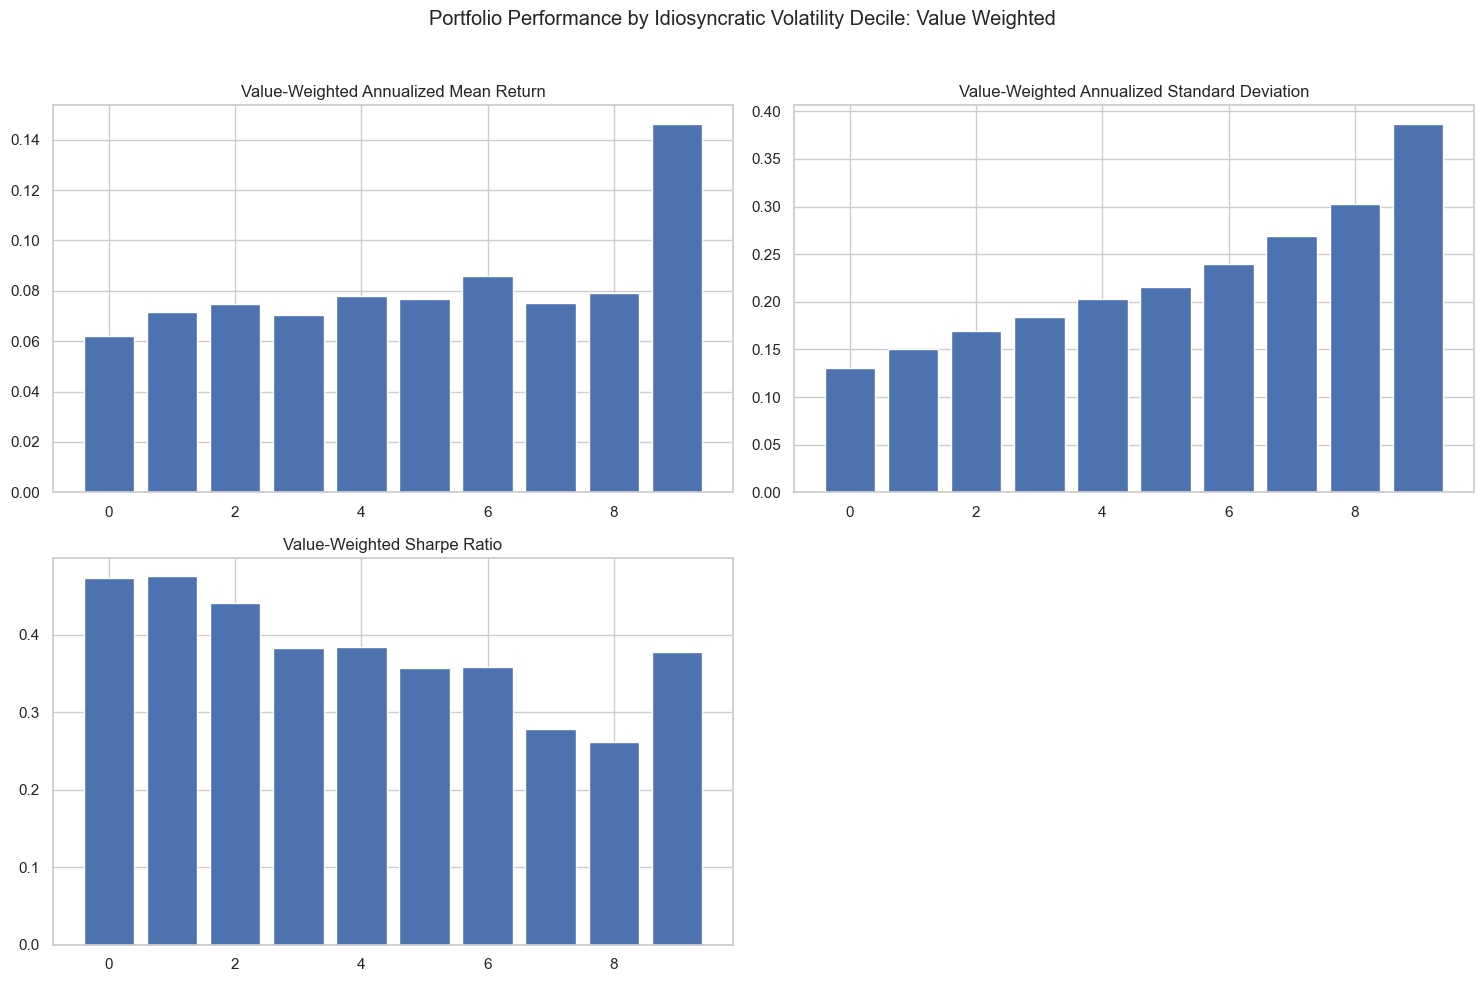

In [25]:
# Plot decile Val weighted
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Portfolio Performance by Idiosyncratic Volatility Decile: Value Weighted')

# Value-Weighted Portfolios
axes[0, 0].bar(vw_stats.index, vw_stats.apply(lambda x: x[0]))
axes[0, 0].set_title('Value-Weighted Annualized Mean Return')

axes[0, 1].bar(vw_stats.index, vw_stats.apply(lambda x: x[1]))
axes[0, 1].set_title('Value-Weighted Annualized Standard Deviation')

axes[1, 0].bar(vw_stats.index, vw_stats.apply(lambda x: x[2]))
axes[1, 0].set_title('Value-Weighted Sharpe Ratio')


# Hide the fourth subplot
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

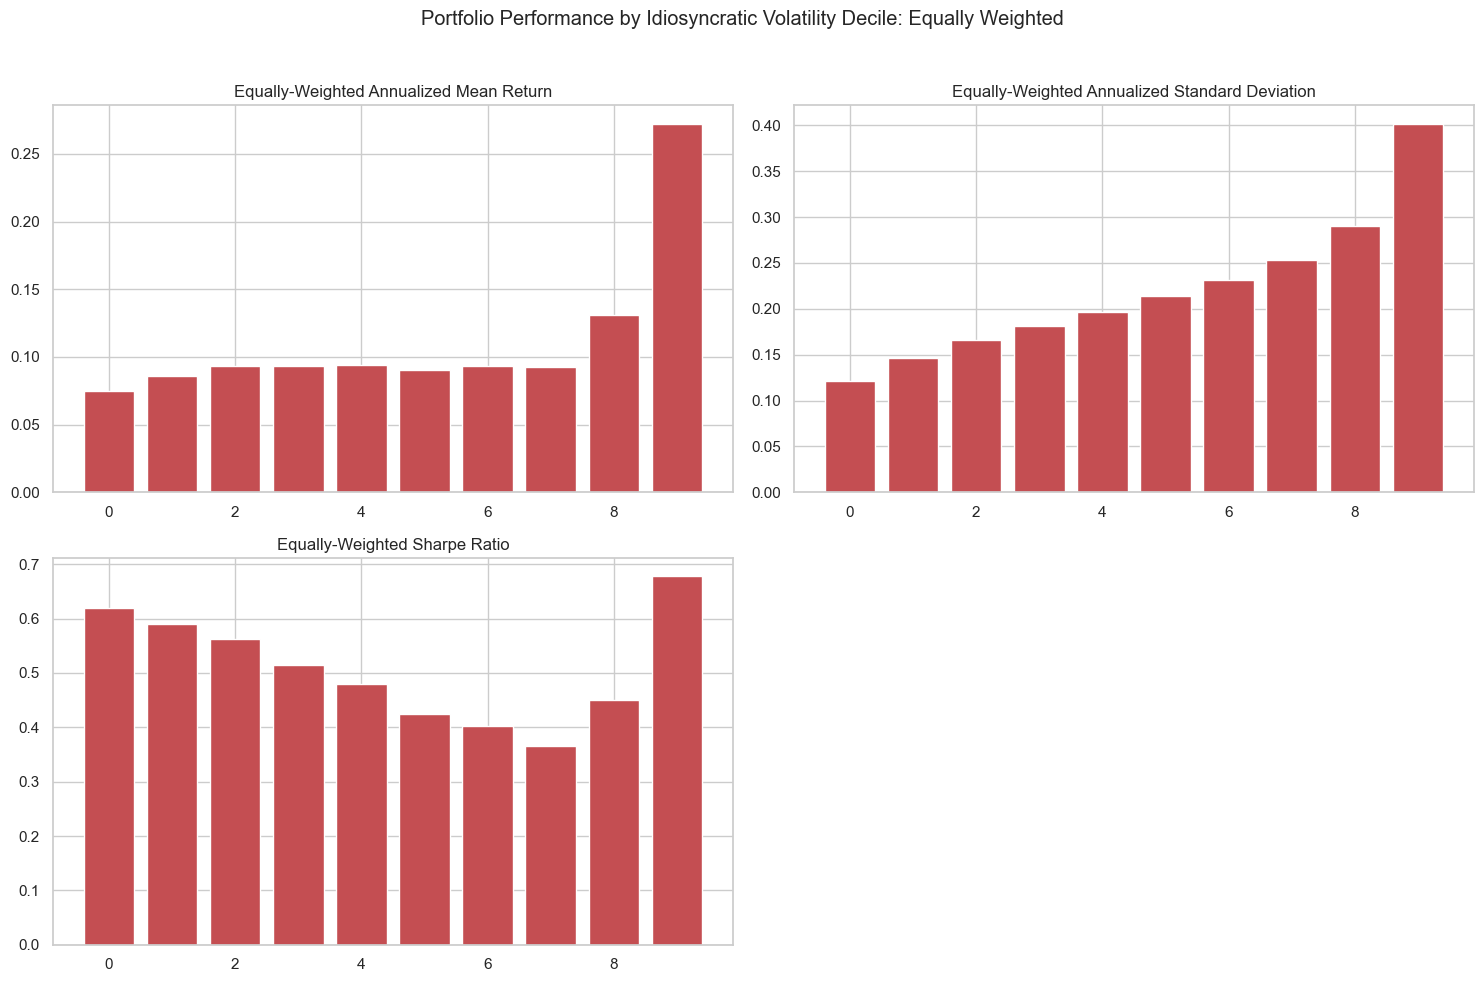

In [26]:
# Plot decile Equal weighted
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Portfolio Performance by Idiosyncratic Volatility Decile: Equally Weighted')

# Equally-Weighted Portfolios
axes[0, 0].bar(ew_stats.index, ew_stats.apply(lambda x: x[0]), color='r')
axes[0, 0].set_title('Equally-Weighted Annualized Mean Return')

axes[0, 1].bar(ew_stats.index, ew_stats.apply(lambda x: x[1]), color='r')
axes[0, 1].set_title('Equally-Weighted Annualized Standard Deviation')

axes[1, 0].bar(ew_stats.index, ew_stats.apply(lambda x: x[2]), color='r')
axes[1, 0].set_title('Equally-Weighted Sharpe Ratio')

# Hide the fourth subplot
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

(c) Now we construct the idiosyncratic volatility factor. At every month t, we go long
the three highest decile volatility portfolios and we go short the three lowest decile
volatility portfolios. Compute and compare the mean, standard deviation, and Sharpe
ratios of the long and short legs of the strategy as well as of the strategy itself. Test if
the strategy has an average return that is statistically significantly different from zero.
Repeat both tests for equal and value-weighted portfolios. How do your results differ
from Ang, Hodrick, Xing, and Zhang (2006; table VI page 285) and what may be the
explanation for the difference?

In [27]:
#  Select stocks for long and short legs
long_leg_data = data[data['sigma_idio_decile'] >= 7]
short_leg_data = data[data['sigma_idio_decile'] < 3]

# Compute portfolio returns for long and short legs
long_leg_returns_vw = long_leg_data.groupby('date')['idio_ret_vw'].sum()
short_leg_returns_vw = -short_leg_data.groupby('date')['idio_ret_vw'].sum()
long_leg_returns_ew = long_leg_data.groupby('date')['Rn_e'].mean()
short_leg_returns_ew = -short_leg_data.groupby('date')['Rn_e'].mean()

# Calculate factor returns
factor_returns_vw = long_leg_returns_vw + short_leg_returns_vw
factor_returns_ew = long_leg_returns_ew + short_leg_returns_ew

# Factor returns
factor_mean_return_vw = factor_returns_vw.mean() * 12
factor_std_dev_vw = factor_returns_vw.std() * np.sqrt(12)
factor_sharpe_ratio_vw = factor_mean_return_vw / factor_std_dev_vw

factor_mean_return_ew = factor_returns_ew.mean() * 12
factor_std_dev_ew = factor_returns_ew.std() * np.sqrt(12)
factor_sharpe_ratio_ew = factor_mean_return_ew / factor_std_dev_ew

# Long and Short legs
long_mean_return_vw = long_leg_returns_vw.mean() * 12
long_std_dev_vw = long_leg_returns_vw.std() * np.sqrt(12)
long_sharpe_ratio_vw = long_mean_return_vw / long_std_dev_vw

short_mean_return_vw = short_leg_returns_vw.mean() * 12
short_std_dev_vw = short_leg_returns_vw.std() * np.sqrt(12)
short_sharpe_ratio_vw = short_mean_return_vw / short_std_dev_vw

long_mean_return_ew = long_leg_returns_ew.mean() * 12
long_std_dev_ew = long_leg_returns_ew.std() * np.sqrt(12)
long_sharpe_ratio_ew = long_mean_return_ew / long_std_dev_ew

short_mean_return_ew = short_leg_returns_ew.mean() * 12
short_std_dev_ew = short_leg_returns_ew.std() * np.sqrt(12)
short_sharpe_ratio_ew = short_mean_return_ew / short_std_dev_ew


# Significance test
t_stat_vw, p_value_vw = ttest_1samp(factor_returns_vw, 0)
t_stat_ew, p_value_ew = ttest_1samp(factor_returns_ew, 0)

In [28]:
# Print results
print("--------- Value-Weighted Portfolio Statistics: ---------")
print("\n--------- Long Leg")
print("Long Leg - Mean Return:", long_mean_return_vw)
print("Long Leg - Standard Deviation:", long_std_dev_vw)
print("Long Leg - Sharpe Ratio:", long_sharpe_ratio_vw)
print("\n--------- Short Leg")
print("Short Leg - Mean Return:", short_mean_return_vw)
print("Short Leg - Standard Deviation:", short_std_dev_vw)
print("Short Leg - Sharpe Ratio:", short_sharpe_ratio_vw)
print("\n--------- Factor Returns")
print("Factor Returns - Mean Return:", factor_mean_return_vw)
print("Factor Returns - Standard Deviation:", factor_std_dev_vw)
print("Factor Returns - Sharpe Ratio:", factor_sharpe_ratio_vw)
print("Factor Returns - T-statistic:", t_stat_vw)
print("Factor Returns - P-value:", p_value_vw)

print("\n--------- Equal-Weighted Portfolio Statistics: ---------")
print("\n--------- Long Leg")
print("Long Leg - Mean Return:", long_mean_return_ew)
print("Long Leg - Standard Deviation:", long_std_dev_ew)
print("Long Leg - Sharpe Ratio:", long_sharpe_ratio_ew)
print("\n--------- Short Leg")
print("Short Leg - Mean Return:", short_mean_return_ew)
print("Short Leg - Standard Deviation:", short_std_dev_ew)
print("Short Leg - Sharpe Ratio:", short_sharpe_ratio_ew)
print("\n--------- Factor Returns")
print("Factor Returns - Mean Return:", factor_mean_return_ew)
print("Factor Returns - Standard Deviation:", factor_std_dev_ew)
print("Factor Returns - Sharpe Ratio:", factor_sharpe_ratio_ew)
print("Factor Returns - T-statistic:", t_stat_ew)
print("Factor Returns - P-value:", p_value_ew)

--------- Value-Weighted Portfolio Statistics: ---------

--------- Long Leg
Long Leg - Mean Return: 0.2622521818816966
Long Leg - Standard Deviation: 0.8248942109568606
Long Leg - Sharpe Ratio: 0.3179221994751174

--------- Short Leg
Short Leg - Mean Return: -0.2083017867608244
Short Leg - Standard Deviation: 0.4388354751496773
Short Leg - Sharpe Ratio: -0.47466943434729647

--------- Factor Returns
Factor Returns - Mean Return: 0.05395039512087217
Factor Returns - Standard Deviation: 0.6006137891004987
Factor Returns - Sharpe Ratio: 0.08982543541278043
Factor Returns - T-statistic: 0.6776712478878363
Factor Returns - P-value: 0.49820998729681176

--------- Equal-Weighted Portfolio Statistics: ---------

--------- Long Leg
Long Leg - Mean Return: 0.15635436291227806
Long Leg - Standard Deviation: 0.2956147018508478
Long Leg - Sharpe Ratio: 0.5289126756326434

--------- Short Leg
Short Leg - Mean Return: -0.08476647850246943
Short Leg - Standard Deviation: 0.14085953028530682
Short Leg

In [29]:
stats_data = pd.DataFrame({
    'Metric': ['Mean Return', 'Standard Deviation', 'Sharpe Ratio'],
    'Factor Returns (Value-Weighted)': [factor_mean_return_vw, factor_std_dev_vw, factor_sharpe_ratio_vw],
    'Factor Returns (Equal-Weighted)': [factor_mean_return_ew, factor_std_dev_ew, factor_sharpe_ratio_ew],
    'Long Leg (Value-Weighted)': [long_mean_return_vw, long_std_dev_vw, long_sharpe_ratio_vw],
    'Short Leg (Value-Weighted)': [short_mean_return_vw, short_std_dev_vw, short_sharpe_ratio_vw],
    'Long Leg (Equal-Weighted)': [long_mean_return_ew, long_std_dev_ew, long_sharpe_ratio_ew],
    'Short Leg (Equal-Weighted)': [short_mean_return_ew, short_std_dev_ew, short_sharpe_ratio_ew]
})
stats_data

,Metric,Factor Returns (Value-Weighted),Factor Returns (Equal-Weighted),Long Leg (Value-Weighted),Short Leg (Value-Weighted),Long Leg (Equal-Weighted),Short Leg (Equal-Weighted)
0,Mean Return,0.053950,0.071588,0.262252,-0.208302,0.156354,-0.084766
1,Standard Deviation,0.600614,0.209832,0.824894,0.438835,0.295615,0.140860
2,Sharpe Ratio,0.089825,0.341167,0.317922,-0.474669,0.528913,-0.601780


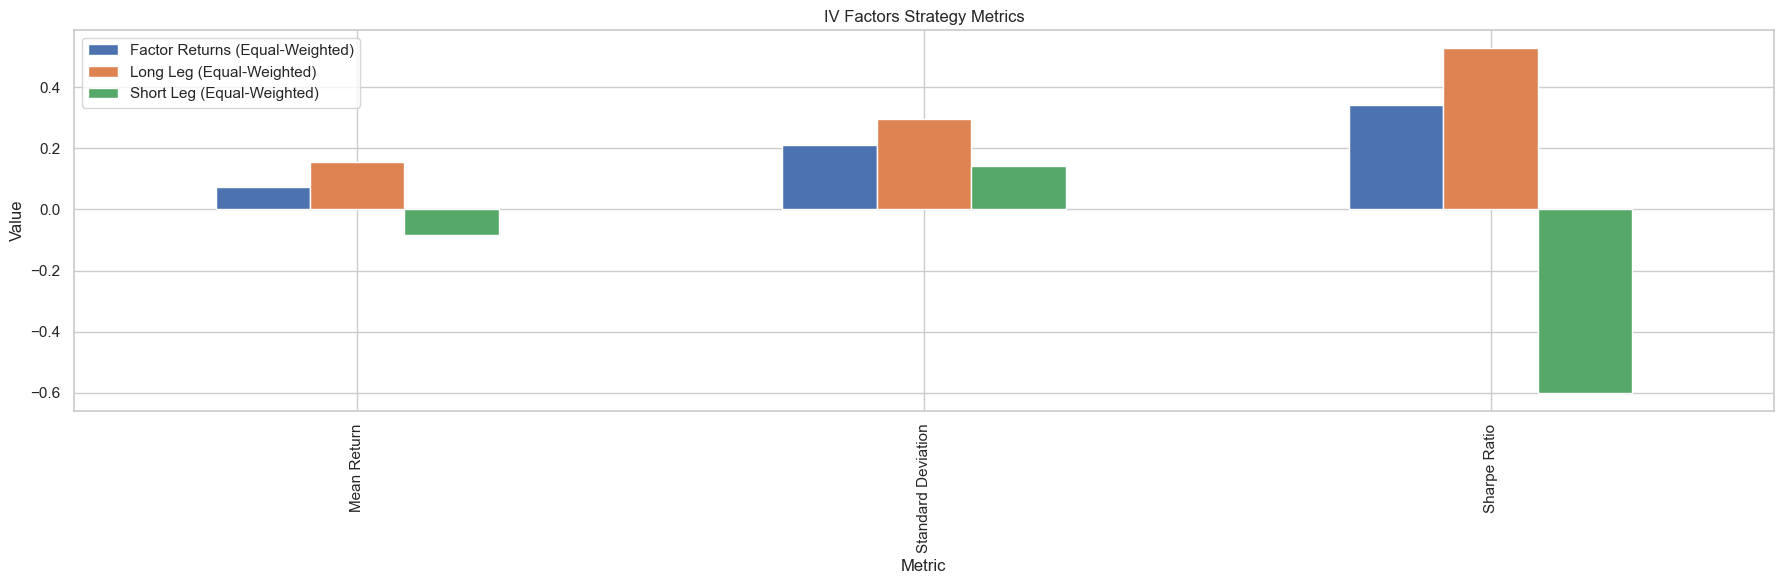

In [30]:
# Stats metrics
metrics = ['Mean Return', 'Standard Deviation', 'Sharpe Ratio']

# Equal-Weighted
plot_strategy_performance(metrics=metrics, data=stats_data, columns=[f'Factor Returns (Equal-Weighted)', f'Long Leg (Equal-Weighted)', f'Short Leg (Equal-Weighted)'])

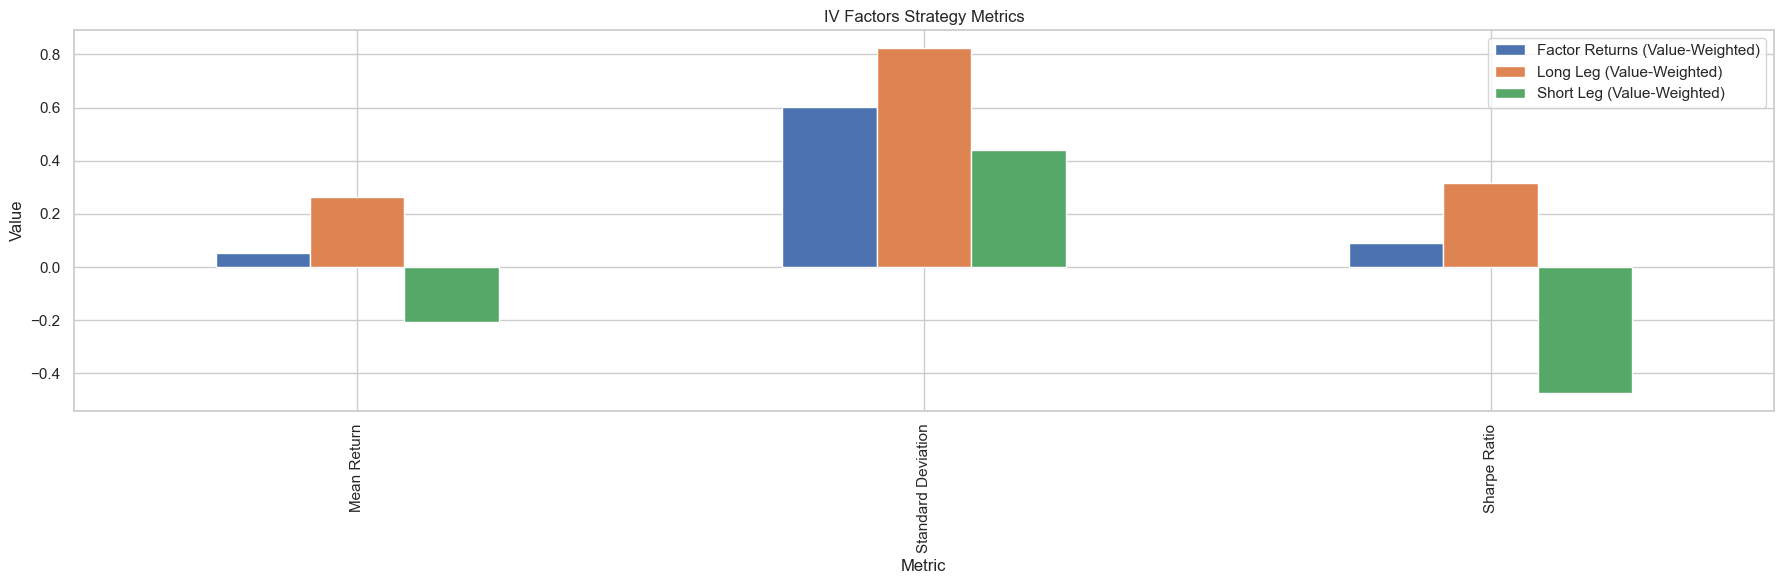

In [31]:
# Value-Weighted
plot_strategy_performance(metrics=metrics, data=stats_data, columns=[f'Factor Returns (Value-Weighted)', f'Long Leg (Value-Weighted)', f'Short Leg (Value-Weighted)'])

In [32]:
# Load data for next section 
IV = factor_returns_vw.reset_index().rename(columns={'idio_ret_vw': 'IV'})
IV['date'] = IV['date'].dt.to_period('M')
IV.to_parquet('../data/factors/iv_returns.parquet')
IV

,date,IV
0,1967-01,0.211974
1,1967-02,0.054560
2,1967-03,-0.028778
3,1967-04,-0.004146
4,1967-05,0.094856
...,...,...
678,2023-08,0.026783
679,2023-09,0.079568
680,2023-10,-0.054791
681,2023-11,-0.092545


In [33]:
WEIGHTS = data[['date', 'permno', 'vw_Q']]
WEIGHTS['date'] = WEIGHTS['date'].dt.to_period('M')
IV.to_parquet('../data/weight/iv_weight.parquet')

/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_70261/3914411283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WEIGHTS['date'] = WEIGHTS['date'].dt.to_period('M')


---
# Imports

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from utils import annualized_metrics, plot_metrics, ew_strategy, rp_strategy, mv_strategy, scale_to_target_volatility

from functools import reduce

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
DATA_PATH = "../data"

---
# 6 - Optimal Fund Portfolio Return (STRAT)

*We now assume that you are running a fund that invests its assets under management in 1-month TBills and adds an ‘overlay’ investment in the three strategies (BaB, IV, MoM) targeting an average annual volatility of 10%. Specifically, consider the return to the fund to be $R_{fund}=R_{T−Bill}+c * R_{STRAT}$,where $R_{STRAT}$ is the return to a strategy that combines BaB, IV, and MoM and where $c$ is a constant that you choose so that the average annual volatility $Vol(c * R_{STRAT})=10\%$.*

*Consider three different approaches to combine the three strategies, BaB, IV, MoM to generate $R_{STRAT}$* :
- *Equal weight the strategies.*
- *Risk-Parity based on the rolling window estimate of the strategy returns volatilities.*
- *Mean-variance optimal combination based on the rolling window mean and covariance matrix of the strategy returns.*

*For each of the three approaches to combining the strategies compute the overall mean, standard deviation, and Sharpe ratio of the resulting ‘optimal’ portfolio. Going forward pick the approach with the risk-parity.*

In [53]:
# Load returns
BaB_returns = pd.read_parquet(f'{DATA_PATH}/factors/bab_returns.parquet')
IV_returns = pd.read_parquet(f'{DATA_PATH}/factors/iv_returns.parquet')
MoM_returns = pd.read_parquet(f'{DATA_PATH}/factors/mom_returns.parquet')
T_bill_returns = pd.read_parquet(f'{DATA_PATH}/tbills.parquet')

returns_dfs = [BaB_returns, IV_returns, MoM_returns, T_bill_returns] 
data = reduce(lambda l,r: pd.merge(l,r, on='date', sort=True), returns_dfs).groupby('date').mean().reset_index()

data.head()

,date,BAB,IV,MoM,rf
0,1969-02,-0.022723,-0.241607,-0.111933,0.004700
1,1969-03,-0.014554,-0.000655,0.092566,0.004468
2,1969-04,-0.010209,0.030453,0.055364,0.005104
3,1969-05,0.017250,-0.026708,0.006153,0.004871
4,1969-06,-0.022097,-0.240808,-0.186902,0.005401


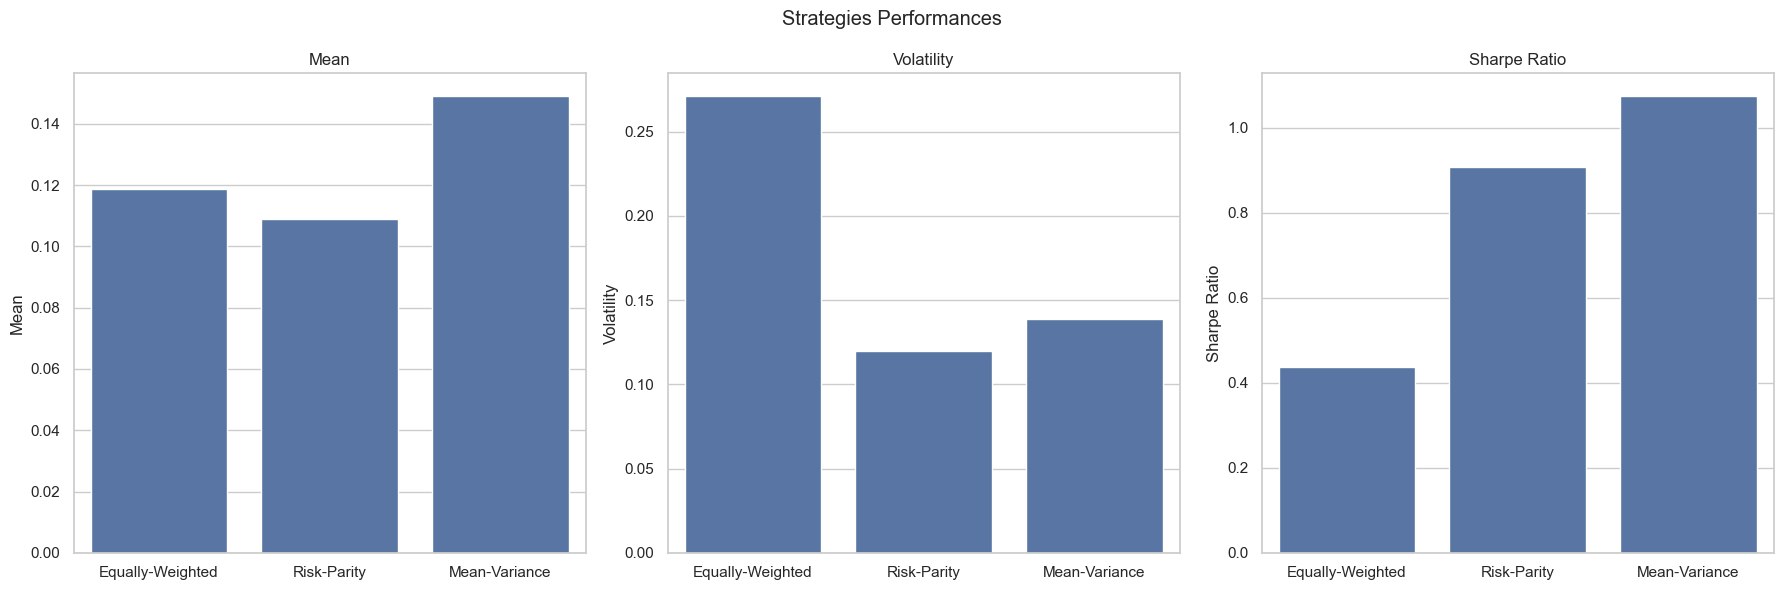

In [54]:
assets = ['rf']
factors_cols = ['BAB', 'IV', 'MoM']

# Calculate strategies
ew_returns = ew_strategy(data, factors_cols)
rp_weights, rp_returns = rp_strategy(data, factors_cols)
mv_returns = mv_strategy(data, factors_cols)

df = pd.DataFrame({
            'Equally-Weighted': ew_returns,
            'Risk-Parity': rp_returns,
            'Mean-Variance': mv_returns
        })

plot_metrics(df, 'Strategies Performances')

In [55]:
# Fund returns
def fund_return(strategy_returns, T_bill):
    return T_bill + scale_to_target_volatility(strategy_returns)

# Compute fund return
fund_ew = fund_return(ew_returns, data['rf'])
fund_rp = fund_return(rp_returns, data['rf'])
fund_mv = fund_return(mv_returns, data['rf'])

annualized_metrics(fund_ew, data['rf']), annualized_metrics(fund_rp, data['rf']), annualized_metrics(fund_mv, data['rf'])

((0.043811113494338035, 0.09993504656760169, 0.43839588812020747),
 (0.0908679510899835, 0.09970538718652734, 0.9113645075164203),
 (0.1074744587880412, 0.10007460917662674, 1.0739433276062471))

In [56]:
df = pd.DataFrame({'date': data['date'], 'STRAT': rp_returns, **rp_weights})
df.to_parquet(f'{DATA_PATH}/strat_returns.parquet')

# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

---
# Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from utils import ew_strategy, rp_strategy, mv_strategy, scale_to_target_volatility

from functools import reduce

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Code from sec6

In [8]:


IV_returns = pd.read_parquet('../data/factors/iv_returns.parquet')
MoM_returns = pd.read_parquet('../data/factors/mom_returns.parquet')
T_bill_returns = pd.read_parquet('../data/tbills.parquet')
bab_returns = pd.read_parquet('../data/factors/bab_returns.parquet')

returns_dfs = [IV_returns, MoM_returns, T_bill_returns,bab_returns] 

data = reduce(lambda l,r: pd.merge(l,r, on='date', sort=True), returns_dfs).groupby('date').mean().reset_index()

assets = ['rf']
factors_cols = ['IV', 'MoM','BAB']

#### loading 


In [9]:
strat_returns = pd.read_parquet('../data/strat_returns.parquet')  # Assuming this file contains the STRAT portfolio returns

FamaF = pd.read_csv('../data/FamaFrench5.txt', delimiter= '\s+')
Industry_Returns = pd.read_csv('../data/12_Industry_Portfolios.txt', delimiter= '\s+')
mom_weights = pd.read_parquet('../data/weight/mom_weights.parquet')
bab_weights = pd.read_parquet('../data/weight/BaB_weights.parquet')
iv_weights = pd.read_parquet('../data/weight/iv_weight.parquet')
weights = strat_returns[['w_IV','w_MoM','w_BAB','date']]
weights.columns = ['IV_weight'	,'MoM_weight'	,'bab_returns',	'date']
strat_returns = strat_returns[['date','STRAT']]

In [10]:
strat_returns

,date,STRAT
0,1969-02,0.000000
1,1969-03,0.000000
2,1969-04,0.000000
3,1969-05,0.000000
4,1969-06,0.000000
...,...,...
654,2023-08,0.003064
655,2023-09,-0.022429
656,2023-10,-0.010493
657,2023-11,0.006988


## a)

In [11]:
Industries = Industry_Returns.columns.tolist()
Industry_Names = pd.DataFrame(Industries,index=np.arange(1,13)).reset_index()
Industry_Names.columns=['Industry','Name']
Industry_Returns = Industry_Returns.reset_index().rename(columns = {'index':'date'})
Industry_Returns['date'] = pd.to_datetime(Industry_Returns['date'], format='%Y%m', errors='coerce')+pd.offsets.MonthEnd(0)
Industry_Returns['date'] = Industry_Returns['date'].dt.to_period('M')

Factors = FamaF.columns.tolist()
Factors_Names = pd.DataFrame(Factors,index=np.arange(1,7)).reset_index()
Factors_Names.columns=['Factor','Name']
FamaF = FamaF.reset_index().rename(columns = {'index':'date'})
FamaF['date'] = pd.to_datetime(FamaF['date'], format='%Y%m', errors='coerce')+pd.offsets.MonthEnd(0)

FamaF.drop('RF', axis=1, inplace = True)
FamaF['date'] = FamaF['date'].dt.to_period('M')


final_reg = strat_returns.merge(Industry_Returns,on='date',how='left').merge(FamaF,on='date',how='left')
final_reg.drop('date', axis=1, inplace = True)

Y = final_reg.iloc[:, 0]
X = final_reg.drop(final_reg.columns[0], axis=1)


import statsmodels.api as sm

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  STRAT   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     57.25
Date:                Fri, 21 Jun 2024   Prob (F-statistic):          3.14e-116
Time:                        18:09:51   Log-Likelihood:                 1586.4
No. Observations:                 659   AIC:                            -3137.
Df Residuals:                     641   BIC:                            -3056.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      3.774      0.000       0.002       0.006
NoDur         -0.0002      0.000     -0.492      0.623      -0.001       0.001
Durbl          0.0006      0.000      3.064      0.002       0.000       0.001
Manuf          0.0014      0.001      2.557      0.011       0.000       0.002
Enrgy          0.0003      0.000      1.192      0.234      -0.000       0.001
Chems         -0.0014      0.000     -3.127      0.002      -0.002      -0.001
BusEq          0.0009      0.000      2.372      0.018       0.000       0.002
Telcm         -0.0002      0.000     -0.515      0.607      -0.001       0.000
Utils          0.0021      0.000      6.845      0.000       0.001       0.003
Shops          0.0011      0.000      2.669      0.008       0.000       0.002
Hlth       -6.944e-05      0.000     -0.213      0.832      -0.001       0.001
Money         -0.0003      0.000     -0.759      0.448      -0.001       0.001
Other         -0.0002      0.001     -0.280      0.780      -0.001       0.001
Mkt-RF         0.0004      0.002      0.289      0.772      -0.003       0.003
SMB            0.0040      0.000     10.666      0.000       0.003       0.005
HML            0.0007      0.001      1.349      0.178      -0.000       0.002
RMW           -0.0008      0.001     -1.441      0.150      -0.002       0.000
CMA            0.0017      0.001      2.502      0.013       0.000       0.003
==============================================================================
Omnibus:                       50.934   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.089
Skew:                           0.241   Prob(JB):                     5.28e-42
Kurtosis:                       5.587   Cond. No.                         33.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## b)

1325994


/var/folders/1y/cd26kgpx7jd535tgk4gkf_3r0000gn/T/ipykernel_24320/2605332955.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_b['FF12'].fillna(12, inplace=True)


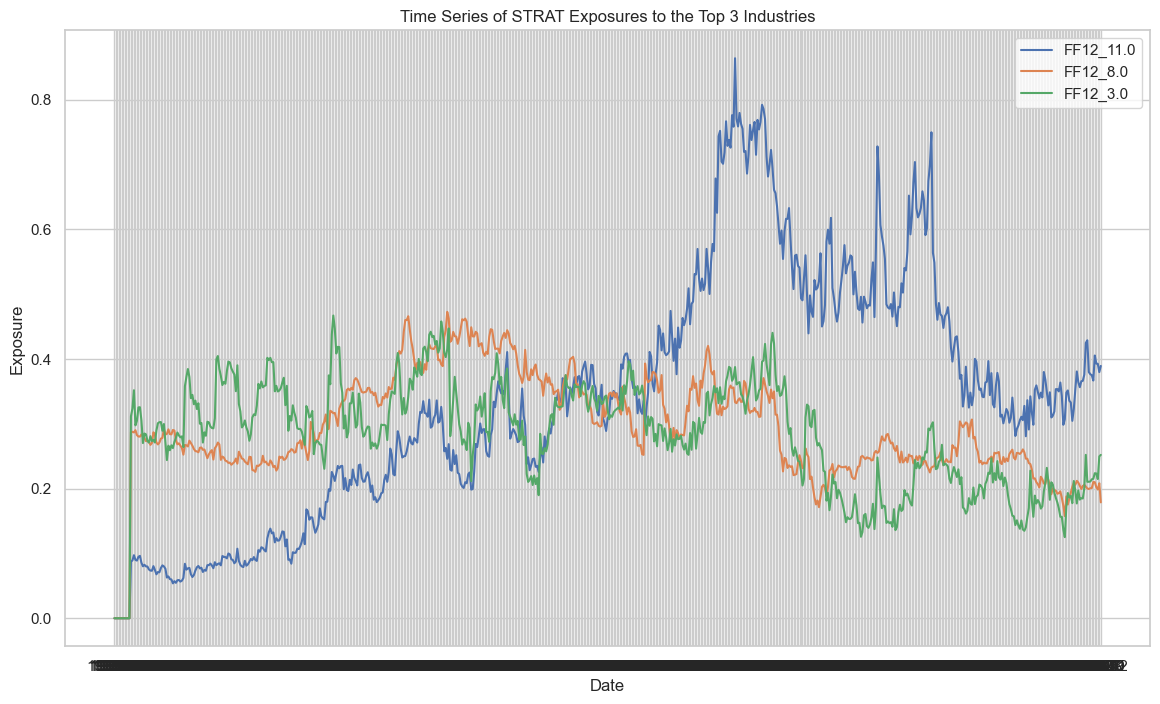

In [12]:
import re
data_b = pd.read_parquet('../data/slow_part.parquet')
print(len(data_b))
with open('../data/Siccodes12.txt', 'r') as file:
    lines = file.readlines()


ff12_mapping = []
current_ff12 = None

for line in lines:
    category_match = re.match(r'^\s*(\d+)\s+\w+', line)
    if category_match:
        current_ff12 = int(category_match.group(1))
    else:   
        interval_match = re.match(r'^\s*(\d+)-(\d+)', line)
        if interval_match:
            start = int(interval_match.group(1))
            end = int(interval_match.group(2))
            ff12_mapping.append((start, end, current_ff12))

def map_siccd_to_ff12(siccd):
    for start, end, ff12 in ff12_mapping:
        if start <= siccd <= end:
            return ff12
    return None


data_b['FF12'] = data_b['siccd'].apply(map_siccd_to_ff12)
data_b['FF12'].fillna(12, inplace=True)

encoded_columns = pd.get_dummies(data_b['FF12'],dtype=int, prefix='FF12')
data_b = pd.concat([data_b, encoded_columns], axis=1)

mom_weights['date'] = mom_weights['date'].dt.strftime('%Y-%m')
bab_weights['date'] = pd.to_datetime(bab_weights['date']).dt.strftime('%Y-%m')

iv_weights['date'] = iv_weights['date'].dt.strftime('%Y-%m')

data_b['date'] = pd.to_datetime(data_b['date']).dt.strftime('%Y-%m')
data_b = data_b.merge(mom_weights, on=['permno','date'], how='right')
data_b = data_b.merge(iv_weights, on=['permno','date'], how='right')

data_b = data_b.merge(bab_weights, on=['permno','date'], how='right')
'''
volatilities = data[factors_cols].rolling(window=12).std()
inverse_vols = 1 / volatilities
weights = inverse_vols.div(inverse_vols.sum(axis=1), axis=0)
weights['date'] = data['date']
strategy_returns = (weights * data[factors_cols]).sum(axis=1)
weights.columns = ['IV_weight', 'MoM_weight', 'bab_returns','date']
'''
weights['date'] = weights['date'].dt.to_timestamp()
weights.date = weights.date.dt.strftime('%Y-%m')
data_b = data_b.merge(weights, on='date', how='left')
data_b['strat_weights'] = data_b['w_MoM_vw']*data_b['MoM_weight'] + data_b['vw_Q']*data_b['IV_weight'] + data_b['bab_returns']*data_b['BaB_strat']

data_b['weighted_beta'] = data_b['beta'] * data_b['strat_weights']
strat_market_exposure = data_b.groupby('date')['weighted_beta'].sum()

industry_exposures = {}
for i in range(1, 13):
    data_b[f'weighted_FF12_{i}.0'] = data_b[f'FF12_{i}.0'] * data_b['strat_weights']
    industry_exposures[f'FF12_{i}.0'] = data_b.groupby('date')[f'weighted_FF12_{i}.0'].sum()

industry_exposures_df = pd.DataFrame(industry_exposures)

top_3_industries = industry_exposures_df.mean().nlargest(3).index

plt.figure(figsize=(14, 8))

for industry in top_3_industries:
    plt.plot(industry_exposures_df.index, industry_exposures_df[industry], label=industry)

plt.title('Time Series of STRAT Exposures to the Top 3 Industries')
plt.xlabel('Date')
plt.ylabel('Exposure')
plt.legend()
plt.show()

## c)

In [13]:
from tqdm import tqdm

industry_returns = pd.DataFrame()
dates = data_b['date'].unique()
data
for date in tqdm(dates):
    daily_data = data_b[data_b['date'] == date]
    for i in range(1, 13):
        industry_stocks = daily_data[daily_data[f'FF12_{i}.0'] == 1.0]
        if not industry_stocks.empty:
            total_mcap = industry_stocks['mcap'].sum()
            industry_return = (industry_stocks['Rn'] * industry_stocks['mcap']).sum() / total_mcap
            industry_returns.loc[date, f'industry_return_{i}'] = industry_return

industry_returns.reset_index(inplace=True)
industry_returns.rename(columns={'index': 'date'}, inplace=True)

industry_exposures_df.reset_index(inplace=True)
strat_returns.date = strat_returns.date.dt.strftime('%Y-%m')
industry_exposures_df.date = pd.to_datetime(industry_exposures_df.date).dt.strftime('%Y-%m')
industry_returns.date = pd.to_datetime(industry_returns.date).dt.strftime('%Y-%m')

data_b = strat_returns.merge(industry_exposures_df, on='date').merge(industry_returns, on='date')


hedged_returns = data_b['STRAT']
for i in range(1, 13):
    industry_col = f'FF12_{i}.0'
    industry_return_col = f'industry_return_{i}'
    data_b[f'hedge_return_{i}'] = data_b[industry_col] * data_b[industry_return_col]
    hedged_returns -= data_b[f'hedge_return_{i}']

data_b['hedged_return'] = hedged_returns

average_return = data_b['hedged_return'].mean()
std_dev = data_b['hedged_return'].std()
sharpe_ratio = average_return / std_dev

print(f"Average Return of Hedged STRAT Portfolio: {average_return}")
print(f"Standard Deviation of Hedged STRAT Portfolio: {std_dev}")
print(f"Sharpe Ratio of Hedged STRAT Portfolio: {sharpe_ratio}")


100%|██████████| 659/659 [00:25<00:00, 26.18it/s]


Average Return of Hedged STRAT Portfolio: -0.022972713864086232
Standard Deviation of Hedged STRAT Portfolio: 0.08291110513035264
Sharpe Ratio of Hedged STRAT Portfolio: -0.2770764402183349


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from utils import plot_metrics

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
DATA_PATH = "../data"
import warnings

---
# 8 - Industry neutral strategy

a) We now consider a different approach to building a portfolio that is not exposed to
industry risk. Repeat the construction of your fund strategy, but perform the strategy construction separately for each industry to build an industry-neutral portfolio.
Specifically, for all the stocks in industry $i$ (where $i \in \{1, \cdots , 12\}$) separately compute
a BaB$_i$ strategy, a IV$_i$, and a MoM$_i$ strategy as proposed above. Then, repeat the fund
strategy of Section 6 for each of the 12 industries, considering the risk-parity approach
to combine the three strategies (BAB$_i$, IV$_i$, and MOM$_i$) in each industry i targeting
a volatility of 10%. You obtain 12 separate strategy returns. Create a table with 12
rows where you report in the columns the mean, standard deviation, Sharpe ratio, and
t-statistic associated with the mean strategy return. Which strategy delivers the most
significant returns within the industry?

In [7]:
import re
data = pd.read_parquet(f'{DATA_PATH}/stock_data.parquet')
with open(f'{DATA_PATH}/Siccodes12.txt', 'r') as file:
    lines = file.readlines()


ff12_mapping = []
current_ff12 = None

for line in lines:
    
    category_match = re.match(r'^\s*(\d+)\s+\w+', line)
    if category_match:
        current_ff12 = int(category_match.group(1))
    else:
        
        interval_match = re.match(r'^\s*(\d+)-(\d+)', line)
        if interval_match:
            start = int(interval_match.group(1))
            end = int(interval_match.group(2))
            ff12_mapping.append((start, end, current_ff12))

def map_siccd_to_ff12(siccd):
    for start, end, ff12 in ff12_mapping:
        if start <= siccd <= end:
            return ff12
    return None


data['FF12'] = data['siccd'].apply(map_siccd_to_ff12)
data['FF12'].fillna(12, inplace=True)

data = data[data.permno.isin(data.permno.unique()[:100])]

display(data.head())
data.shape

/var/folders/1y/cd26kgpx7jd535tgk4gkf_3r0000gn/T/ipykernel_24792/3681598413.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['FF12'].fillna(12, inplace=True)


,permno,date,Rn,shrout,prc,siccd,Rm,rf,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m,FF12
5,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,-0.037172,0.000013,43871.6600,44918.3000,-0.000656,1,-0.018945,-0.037185,0.000005,8.0
4,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.034744,0.000061,43646.6324,43871.6600,0.020643,1,-0.000717,0.034683,0.000005,8.0
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.063668,0.000112,44351.3700,43646.6324,0.124385,1,0.020531,0.063556,0.000005,8.0
2,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.020036,0.000118,69137.3000,44351.3700,0.004829,1,0.124267,0.019918,0.000004,8.0
1,10001,2010-05-28,0.004829,6071.0,11.4000,4925,-0.079240,0.000114,69209.4000,69137.3000,-0.043421,1,0.004715,-0.079354,0.000007,8.0


(17377, 16)

In [8]:
from stratsgit import iv

industry_iv_strategies=list()

for i in range(1,13):
    industry_iv_strategies.append(iv(i))
    


In [9]:
from stratsgit import mom

industry_mom_strategies=list()

for i in range(1,13):
    industry_mom_strategies.append(mom(i))
    
print(industry_mom_strategies)


[        date       MoM
0    1964-12  0.041725
1    1965-01  0.123752
2    1965-02 -0.003598
3    1965-03  0.020872
4    1965-04  0.087199
..       ...       ...
703  2023-08 -0.122669
704  2023-09 -0.141136
705  2023-10 -0.078988
706  2023-11  0.267287
707  2023-12  0.199999

[708 rows x 2 columns],         date       MoM
0    1964-12 -0.010097
1    1965-01  0.056649
2    1965-02 -0.011770
3    1965-03  0.060749
4    1965-04  0.062705
..       ...       ...
703  2023-08 -0.333441
704  2023-09 -0.104409
705  2023-10 -0.248949
706  2023-11  0.153547
707  2023-12  0.245128

[708 rows x 2 columns],         date       MoM
0    1964-12 -0.082107
1    1965-01  0.130744
2    1965-02  0.044663
3    1965-03  0.004288
4    1965-04  0.078589
..       ...       ...
703  2023-08 -0.074757
704  2023-09 -0.108283
705  2023-10  0.014173
706  2023-11  0.071976
707  2023-12  0.168938

[708 rows x 2 columns],         date       MoM
0    1964-12  0.034059
1    1965-01  0.043437
2    1965-02 -0.040703
3   

In [10]:
from stratsgit import bab

industry_bab_strategies=list()

for i in range(1,13):
    industry_bab_strategies.append(bab(i))
    
print(industry_bab_strategies)


[          date       BAB
0      1969-02 -0.020069
172    1969-03 -0.010185
346    1969-04  0.006340
529    1969-05  0.015053
715    1969-06 -0.021468
...        ...       ...
95197  2023-08 -0.004722
95260  2023-09 -0.090583
95323  2023-10 -0.121905
95388  2023-11 -0.040277
95453  2023-12  0.003554

[659 rows x 2 columns],           date       BAB
0      1969-02  0.006338
91     1969-03 -0.010479
182    1969-04  0.010994
276    1969-05 -0.031587
372    1969-06 -0.000229
...        ...       ...
41933  2023-08  0.018139
41966  2023-09  0.008848
41999  2023-10  0.033546
42032  2023-11  0.005385
42065  2023-12  0.035546

[659 rows x 2 columns],            date       BAB
0       1969-02 -0.012502
374     1969-03  0.012957
752     1969-04 -0.000322
1146    1969-05  0.018904
1538    1969-06 -0.002090
...         ...       ...
189580  2023-08  0.015351
189730  2023-09 -0.022038
189880  2023-10  0.000482
190029  2023-11  0.000754
190178  2023-12  0.021871

[659 rows x 2 columns],           da

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from functools import reduce
from utils import annualized_metrics, plot_metrics, ew_strategy, rp_strategy, mv_strategy, scale_to_target_volatility

riskmerge = list()

# Function to convert 'date' columns to datetime
def convert_date_column(df, column_name='date'):
    if isinstance(df[column_name].dtype, pd.PeriodDtype):
        df[column_name] = df[column_name].dt.to_timestamp()
    df[column_name] = pd.to_datetime(df[column_name]).dt.to_period('M')
    return df

# Function to calculate t-statistic
def calculate_t_stat(mean, std, n):
    return mean / (std / np.sqrt(n))

# Placeholder for storing results
results = []

for i in range(0, 12):
    # Load the T_bill_returns DataFrame
    T_bill_returns = pd.read_parquet(f'{DATA_PATH}/tbills.parquet')
    
    
    # Convert 'date' column in strategies and T_bill_returns to datetime
    bab_df = convert_date_column(industry_bab_strategies[i])
    iv_df = convert_date_column(industry_iv_strategies[i])
    mom_df = convert_date_column(industry_mom_strategies[i])
    T_bill_returns = convert_date_column(T_bill_returns)

    # Filter the datasets to start from 1969-02
    start_date = '1969-02'
    bab_df = bab_df[bab_df['date'] >= start_date]
    iv_df = iv_df[iv_df['date'] >= start_date]
    mom_df = mom_df[mom_df['date'] >= start_date]

    # Prepare the list of DataFrames to merge
    returns_dfs = [bab_df, iv_df, mom_df, T_bill_returns]

    # Merge the DataFrames on 'date' column
    data = reduce(lambda left, right: pd.merge(left, right, on='date', sort=True), returns_dfs).groupby('date').mean().reset_index()

    # Convert 'date' column to string format 'YYYY-MM'
    data['date'] = data['date'].dt.strftime('%Y-%m')

    # Define assets and factors columns
    assets = ['rf']
    factors_cols = ['BAB', 'IV', 'MoM']
    # Calculate risk-parity returns
    rp_returns = rp_strategy(data, factors_cols)[1]
    df_rp_ret = pd.DataFrame({'date': data['date'], 'STRAT': rp_returns})

    # Create DataFrame for risk-parity returns
    df = pd.DataFrame({'Risk-Parity': rp_returns})

    # Function to calculate fund return
    def fund_return(strategy_returns, T_bill):
        return T_bill + scale_to_target_volatility(strategy_returns)

    # Calculate fund returns for risk-parity strategy

    df_rp_ret['fund_rp'] = fund_return(rp_returns.values, data['rf'])
    df_rp_ret.drop(columns='STRAT',inplace=True)
    riskmerge.append(df_rp_ret)

    # Calculate annualized metrics
    mean_return, std_dev, sharpe_ratio = annualized_metrics(df_rp_ret['fund_rp'])

    # Calculate t-statistic
    
    t_stat = calculate_t_stat(mean_return, std_dev, len(df_rp_ret['fund_rp']))

    # Append results for the current industry
    results.append({
        'Industry': i + 1,
        'Mean': mean_return,
        'Standard Deviation': std_dev,
        'Sharpe Ratio': sharpe_ratio,
        't-Statistic': t_stat
    })

# Create a DataFrame for the results
results_df = pd.DataFrame(results, columns=['Industry', 'Mean', 'Standard Deviation', 'Sharpe Ratio', 't-Statistic'])

# Display the results
print(results_df)


    Industry      Mean  Standard Deviation  Sharpe Ratio  t-Statistic
0          1  0.095701            0.100633      0.950987    24.412776
1          2  0.088384            0.100573      0.878805    22.559804
2          3  0.114106            0.100175      1.139073    29.241139
3          4  0.087960            0.100079      0.878907    22.562411
4          5  0.099613            0.100282      0.993336    25.499930
5          6  0.093732            0.099393      0.943038    24.208719
6          7  0.095488            0.100211      0.952872    24.461180
7          8  0.107521            0.100449      1.070403    27.478303
8          9  0.117009            0.099964      1.170516    30.048318
9         10  0.081932            0.099649      0.822206    20.522230
10        11  0.088327            0.099854      0.884557    21.721245
11        12  0.111800            0.099868      1.119476    28.738066


*b) Now combine these 12 returns using equal weights to generate a new industry-neutral STRAT. Compute the mean, standard deviation, and Sharpe ratio associated with this
new strategy. How does its performance compare to that of the previous STRAT and
the previously hedged STRAT?*

In [13]:
merged = riskmerge[0]
for idx,l in enumerate(riskmerge[1:]):   
    merged = merged.merge(l,on='date',suffixes=(str(idx),str(idx+1)))
           

In [14]:
merged['mean'] = (merged['fund_rp0'] + merged['fund_rp1'] + merged['fund_rp2'] +merged['fund_rp3'] +merged['fund_rp4'] +merged['fund_rp5'] +merged['fund_rp6'] +merged['fund_rp7'] +merged['fund_rp8'] +merged['fund_rp9'] +merged['fund_rp10'] +merged['fund_rp11'])/12 


In [15]:
mean_return, std_dev, sharpe_ratio = annualized_metrics(merged['mean'])
print('Mean', mean_return,
        'Standard Deviation', std_dev,
        'Sharpe Ratio', sharpe_ratio)


Mean 0.10015477168879464 Standard Deviation 0.05520989823169347 Sharpe Ratio 1.8140727459501162


*c) Regress the industry-neutral STRAT onto the 17 risk factors (12 industry portfolio
returns and 5 Fama-French Research Factors from Ken French’s website). Discuss the
alpha, betas, and R-square of that regression. How does it compare to the results you
get in Section 7a?*

In [16]:
Industry_Returns = pd.read_csv(f'{DATA_PATH}/12_Industry_Portfolios.txt', delimiter= '\s+')
Industries = Industry_Returns.columns.tolist()
Industry_Names = pd.DataFrame(Industries,index=np.arange(1,13)).reset_index()
Industry_Names.columns=['Industry','Name']
Industry_Returns = Industry_Returns.reset_index().rename(columns = {'index':'date'})
Industry_Returns['date'] = pd.to_datetime(Industry_Returns['date'], format='%Y%m', errors='coerce')+pd.offsets.MonthEnd(0)
Industry_Returns['date'] = Industry_Returns['date'].dt.to_period('M')

FamaF = pd.read_csv(f'{DATA_PATH}/FamaFrench5.txt', delimiter= '\s+')
Factors = FamaF.columns.tolist()
Factors_Names = pd.DataFrame(Factors,index=np.arange(1,7)).reset_index()
Factors_Names.columns=['Factor','Name']
FamaF = FamaF.reset_index().rename(columns = {'index':'date'})
FamaF['date'] = pd.to_datetime(FamaF['date'], format='%Y%m', errors='coerce')+pd.offsets.MonthEnd(0)

FamaF.drop('RF', axis=1, inplace = True)
FamaF['date'] = FamaF['date'].dt.to_period('M')



In [17]:
merged = merged[['date','mean']]

In [18]:
FamaF.date = FamaF.date.dt.strftime('%Y-%m')

In [19]:
Industry_Returns.date = Industry_Returns.date.dt.strftime('%Y-%m')


In [20]:
final_reg = merged.merge(Industry_Returns,on='date',how='left').merge(FamaF,on='date',how='left')

In [21]:
final_reg

,date,mean,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,Mkt-RF,SMB,HML,RMW,CMA
0,1969-02,0.004700,-6.59,-3.47,-6.04,-4.60,-4.63,-3.57,-3.33,-5.21,-4.13,-5.16,-8.76,-8.17,-5.84,-4.16,0.91,2.07,0.83
1,1969-03,0.004468,0.71,5.11,3.07,7.12,1.06,5.47,-0.42,-1.29,5.06,3.34,3.33,-0.43,2.64,-0.45,-0.51,-1.43,-0.35
2,1969-04,0.005104,1.06,1.22,1.51,-0.36,0.62,4.05,7.73,1.33,3.77,4.98,2.89,1.24,1.46,-0.80,-0.03,0.41,0.06
3,1969-05,0.004871,1.21,0.14,-1.36,3.76,0.97,-1.79,1.08,0.03,0.55,1.68,-1.36,-1.17,-0.10,-0.11,0.70,-0.95,1.39
4,1969-06,0.005401,-7.31,-5.99,-7.14,-9.89,-6.30,-0.02,-4.00,-5.73,-5.49,-5.04,-10.05,-10.99,-7.18,-5.45,-1.08,4.32,-1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,2023-08,0.016305,-3.77,-4.31,-2.21,1.95,-2.75,-1.67,0.14,-5.29,-0.40,-0.22,-3.61,-2.98,-2.39,-3.65,-1.06,3.43,-2.37
597,2023-09,-0.017437,-4.57,-2.58,-7.30,3.17,-6.57,-5.95,-3.22,-5.04,-5.68,-4.71,-2.04,-5.57,-5.24,-1.80,1.52,1.86,-0.83
598,2023-10,-0.002689,-3.53,-17.88,-3.01,-6.24,-2.21,-1.73,-0.18,1.12,0.47,-4.58,-1.78,-3.78,-3.19,-4.05,0.18,2.47,-0.65
599,2023-11,0.021168,5.02,15.76,9.73,-1.29,6.28,11.94,6.97,5.08,7.18,5.87,10.25,10.73,8.84,-0.12,1.64,-3.91,-1.00


In [22]:
final_reg.drop('date', axis=1, inplace = True)

Y = final_reg.iloc[:, 0]
X = final_reg.drop(final_reg.columns[0], axis=1)


import statsmodels.api as sm

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     37.90
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           1.13e-82
Time:                        18:34:50   Log-Likelihood:                 1859.0
No. Observations:                 601   AIC:                            -3682.
Df Residuals:                     583   BIC:                            -3603.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.001      9.078      0.0